# Modeling EuroBERT Notebook (Boizard et al. 2025)

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch.nn as nn

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold,
    plot_skorch_history
)

from src.eurobert_skorch import make_eurobert_skorch #eurobert end-to-end from boizard et al 2025
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test for our new fasttext_vectorizer (pretrained static embeddings)

In [2]:
# --- Repro Setup --- we try to make everything reproducible
import os, random, numpy as np, torch
SEED = 42  #global seed

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('high')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)


In [3]:
import torch #we want to use the gpu

print("Torch-Version:", torch.__version__)
print("CUDA-Toolchain in Torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU-Name:", torch.cuda.get_device_name(0))

#test
x = torch.randn(5000, 5000, device="cuda")
y = torch.matmul(x, x)
print("Device:", y.device)


Torch-Version: 2.5.1
CUDA-Toolchain in Torch: 12.4
CUDA available: True
GPU-Name: NVIDIA GeForce RTX 4050 Laptop GPU
Device: cuda:0


In [4]:
#debug
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 

**a) EuroBERT Classifier with basic preprocessed data**

In [5]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

EuroBERT TPE basic

In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_eurobert = Pipeline([
    ("clf", make_eurobert_skorch(
        model_name="EuroBERT/EuroBERT-210m",
        max_length=1000,
        max_epochs=5,
        lr=2e-5,
        batch_size=16,
        force_cuda=True
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    "clf__lr": lambda t: t.suggest_float("clf__lr", 1e-5, 1e-4, log=True),
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16, 32]),
    "clf__max_epochs": lambda t: t.suggest_int("clf__max_epochs", 3, 5),
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 0.01, 0.1),
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("bert_pos_weight", 1.0, 50.0)], dtype=torch.float32),
}

model_name = "eurobert_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_eurobert,
    param_space=param_space,
    X=X_dev,
    y=y_dev,
    cv=cv,
    model_type="eurobert",
    n_trials=50,           
    n_startup_trials=5,
    n_warmup_steps=3,
    intervall_steps=1,
    direction="maximize",
    random_state=SEED,
    verbose=False,
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=SEED
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead with fasttext embeddings
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tdoro\.cache\huggingface\hub\models--EuroBERT--EuroBERT-210m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To su

TypeError: new(): invalid data type 'str'

biLSTM GridSearch basic

Starting Optuna hyperparameter optimization ...
[FastTextVectorizer] LOADING .bin from c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code/src/fasttext_embeddings\cc.de.300.bin
[FastTextVectorizer] CACHED under ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer

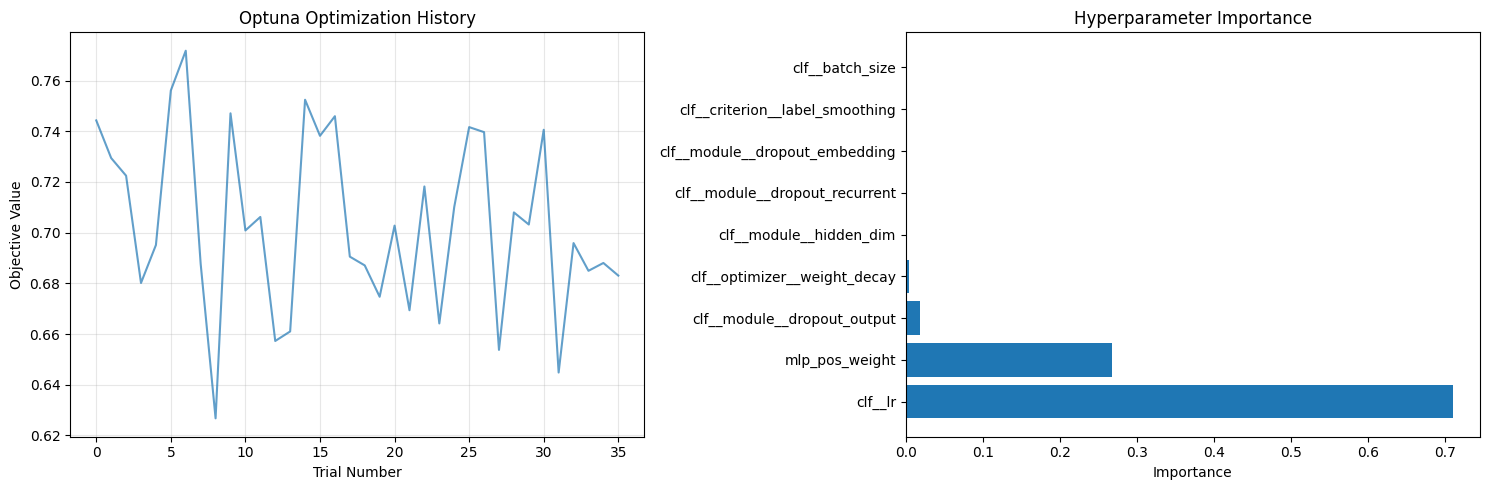


2. Parameter Value Distributions:


c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code\src\optuna_visualizations.py:208: RuntimeWarning: divide by zero encountered in log10
  np.log10(min(numeric_values)),
c:\Users\tdoro\miniconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\tdoro\miniconda3\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


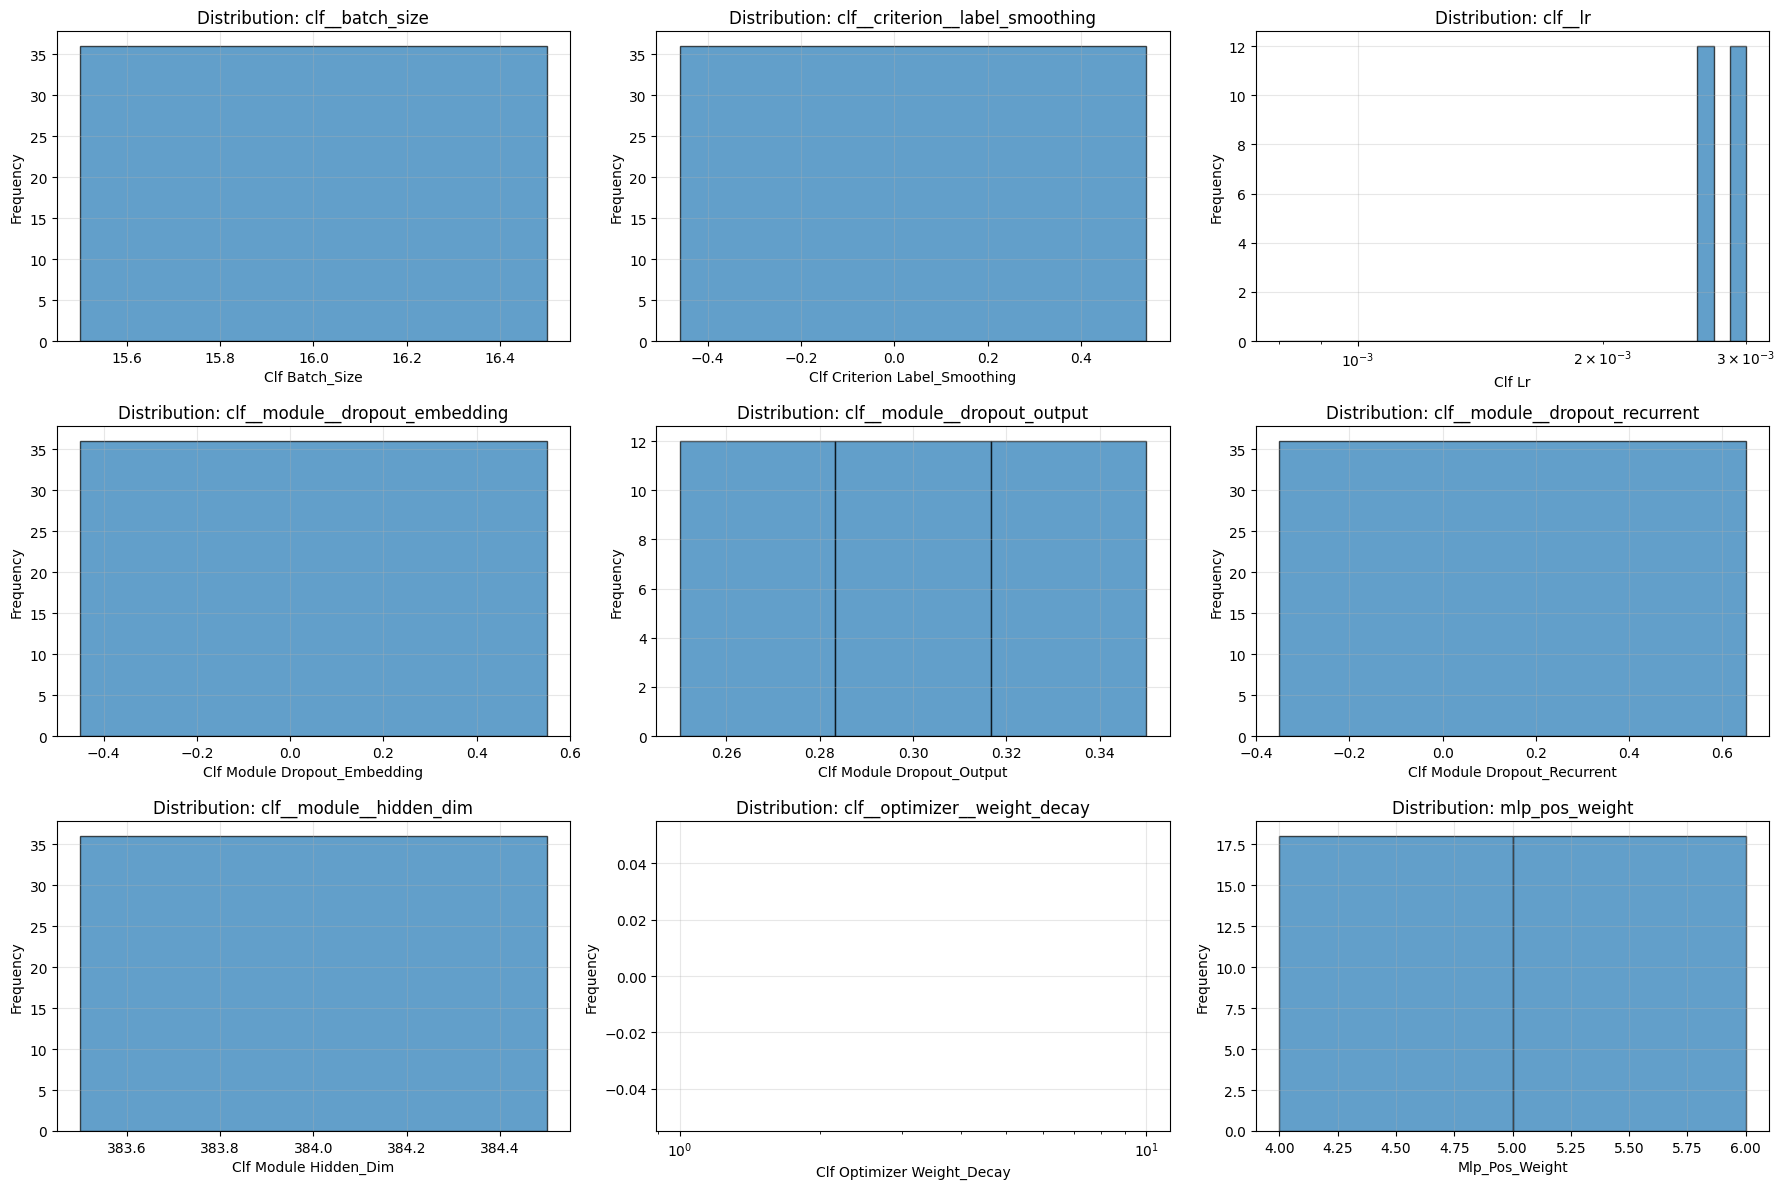


3. Performance vs Individual Parameters:


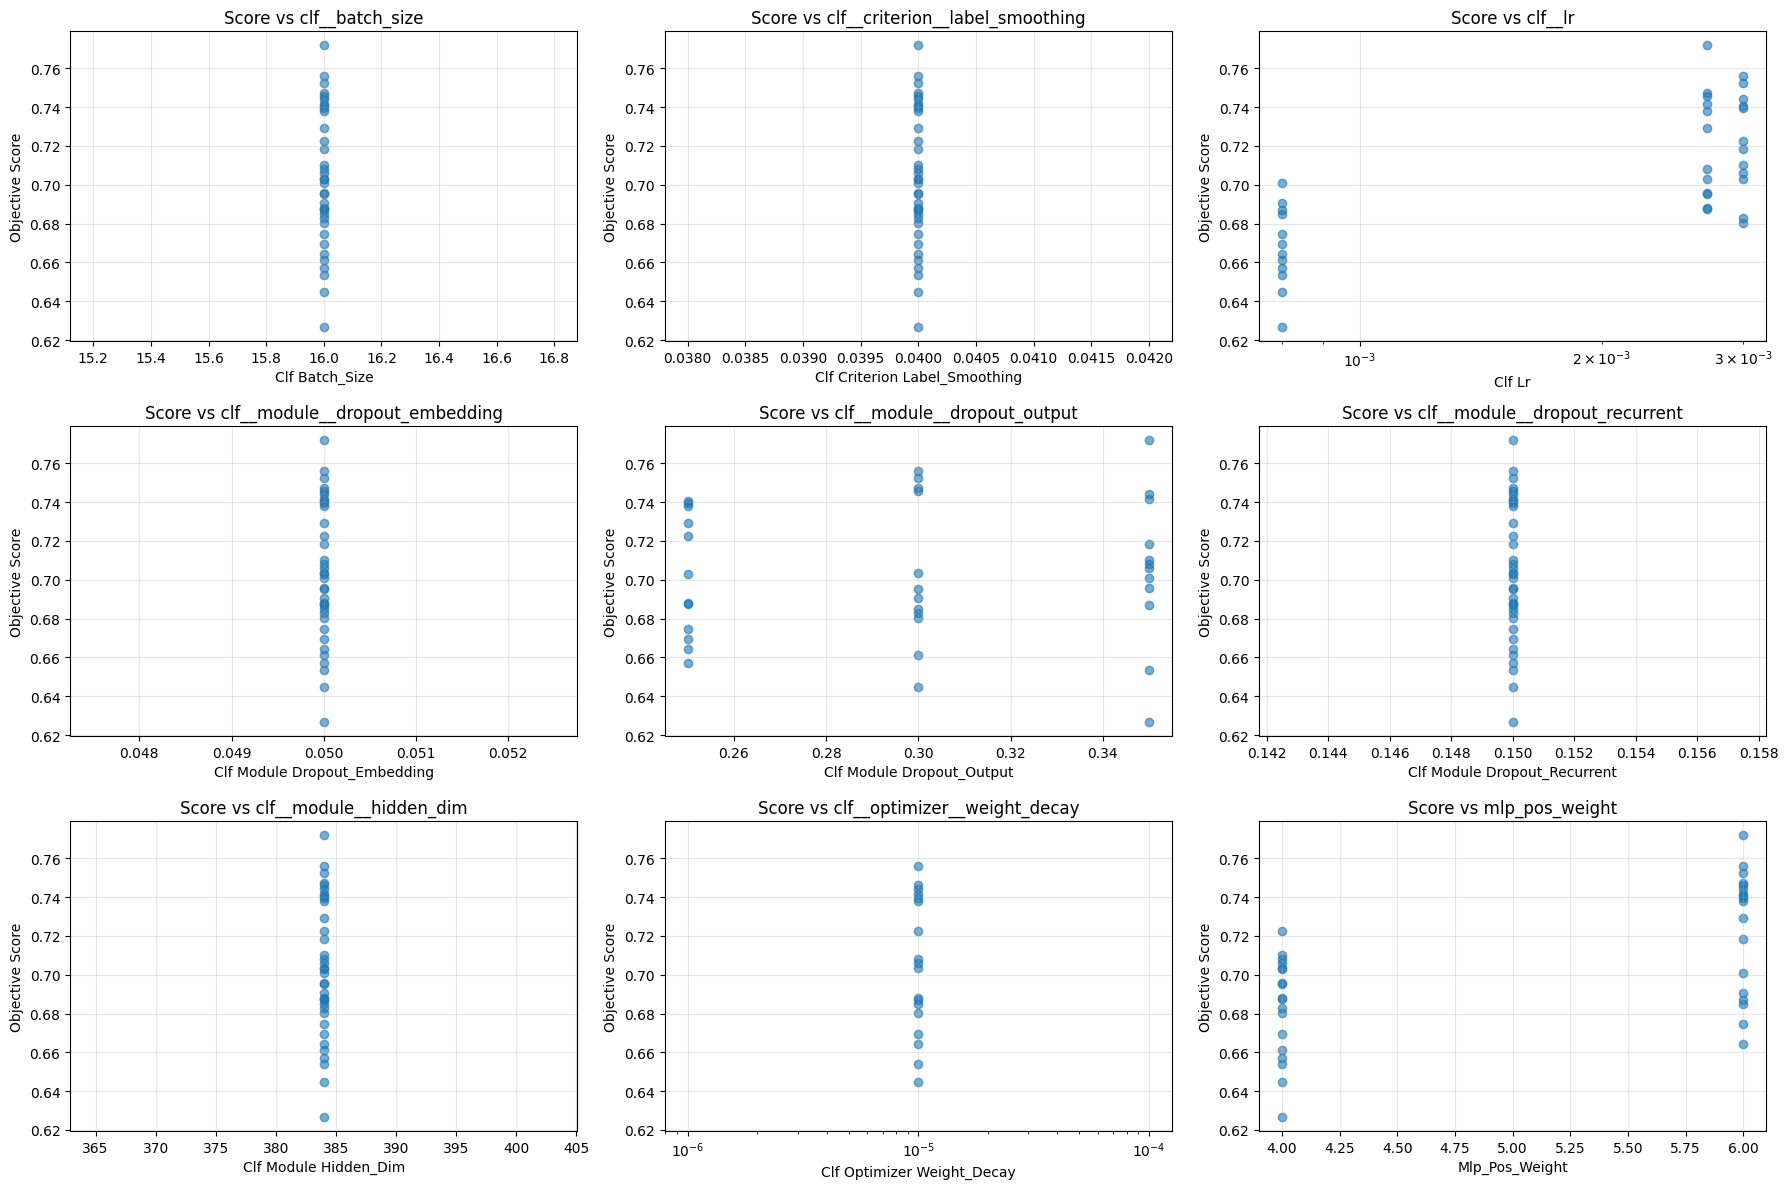


4. Convergence Analysis:


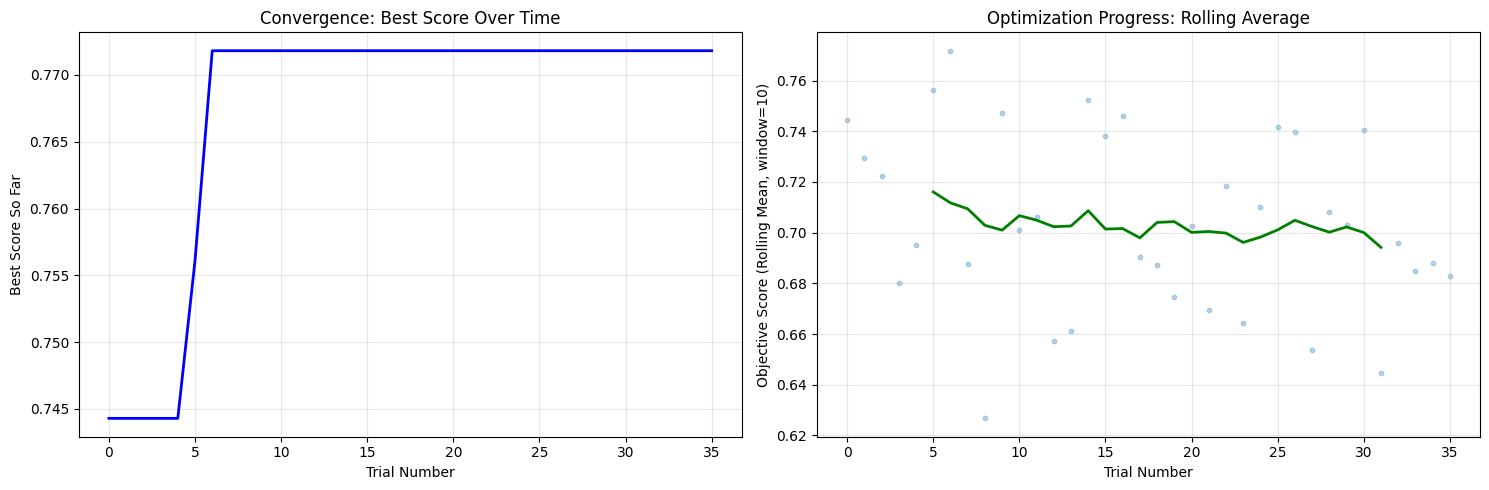


5. Trial Status Overview:


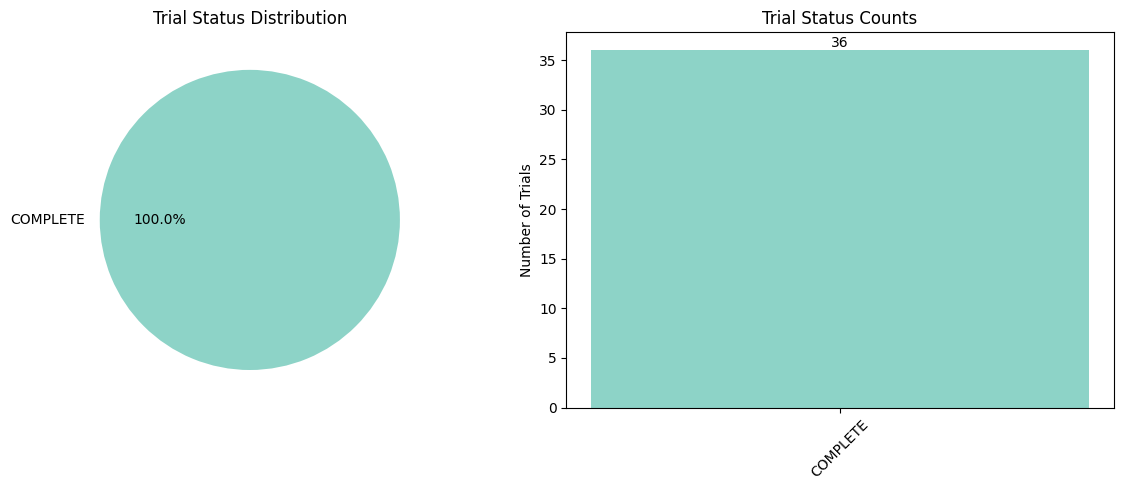


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_embedding dropout_output dropout_recurrent hidden_dim   weight_decay mlp_pos_weight
-------------------------------------------------------------------------------------------------------------------------------------------------------------
1    6       0.7718     16           0.0400       0.0027       0.0500       0.3500       0.1500       384          0.0000       6.0000      
2    5       0.7561     16           0.0400       0.0030       0.0500       0.3000       0.1500       384          0.0000       6.0000      
3    14      0.7525     16           0.0400       0.0030       0.0500       0.3000       0.1500       384          0.0000       6.0000      
4    9       0.7471     16           0.0400       0.0027       0.0500       0.3000       0.1500       384          0.0000       6.0000      
5    16      0.7460     16           0.0400       0.0027       0.0500       0.3000       0.1500 

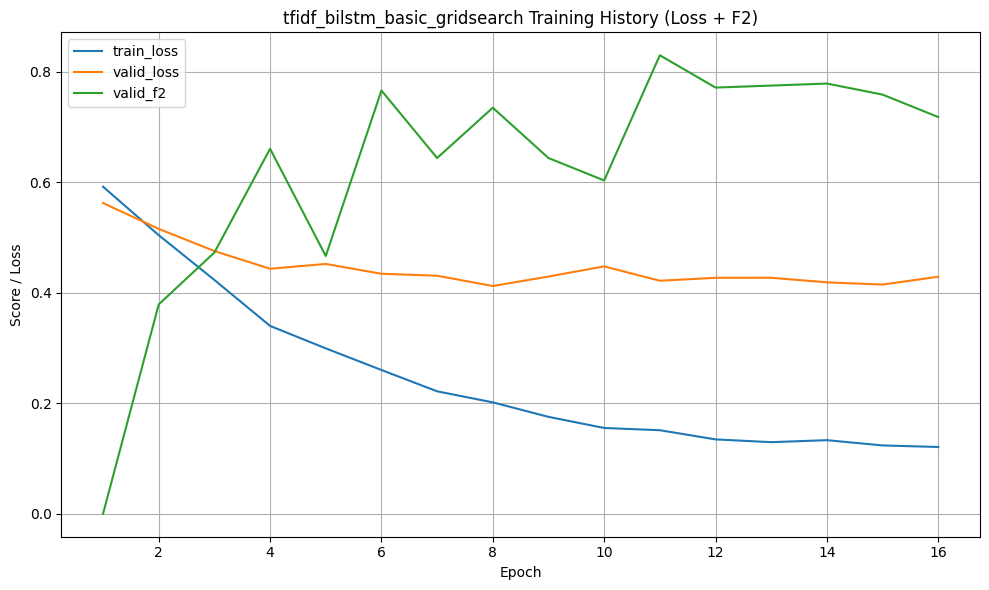


Optimizing threshold with nested cross-validation (coarse-to-fine)...
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.

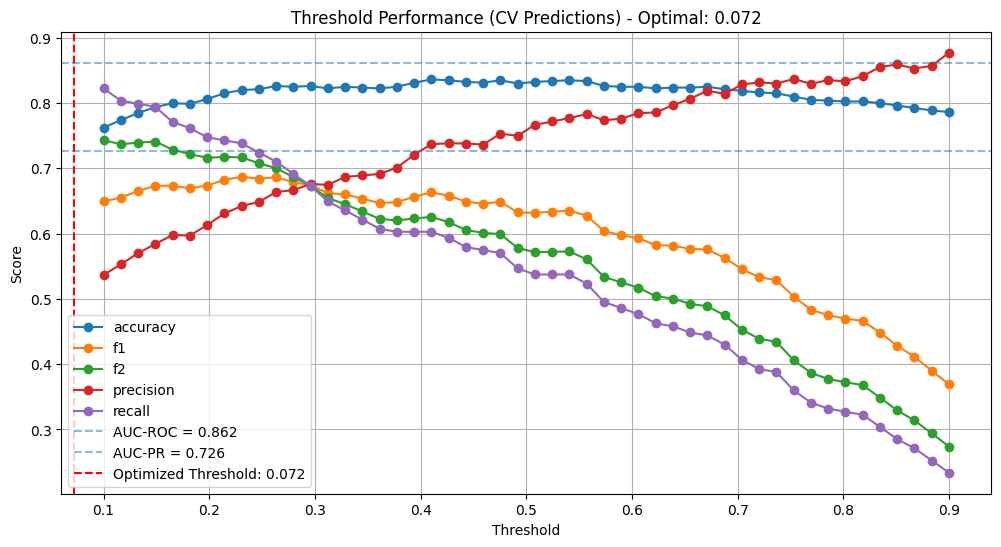

[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

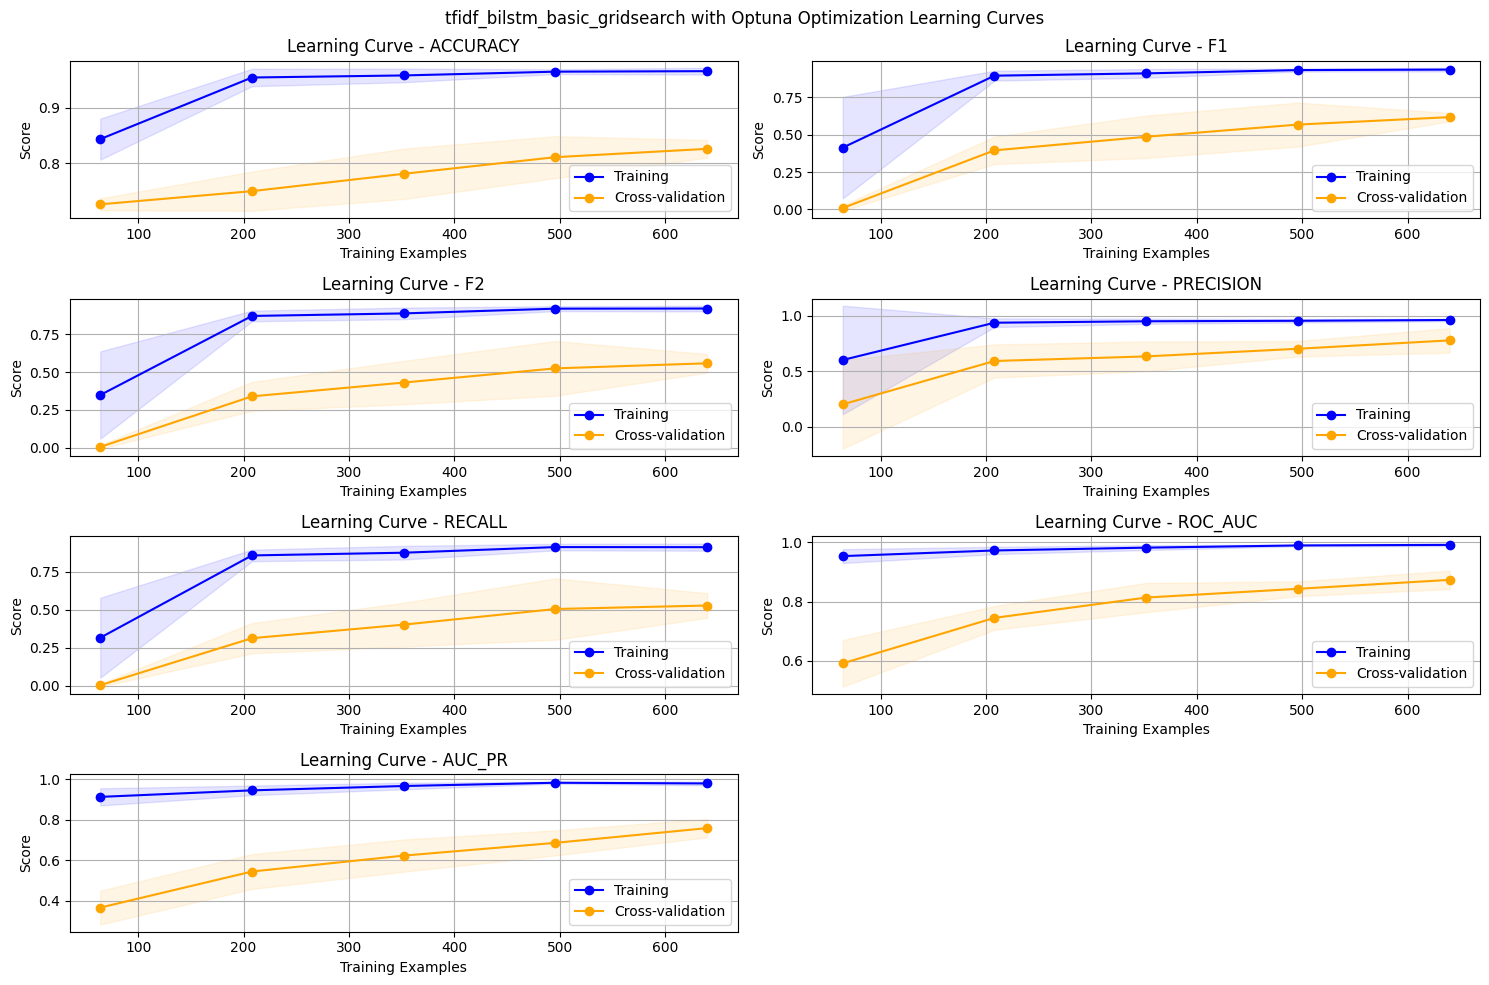


Final Threshold: 0.07
F2-score with default threshold (0.5): 0.504

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       146
           1       0.52      0.80      0.63        54

    accuracy                           0.74       200
   macro avg       0.71      0.76      0.72       200
weighted avg       0.80      0.74      0.76       200

Additional Metrics:
Accuracy   0.745
F2-score   0.719
AUC-ROC    0.845
AUC-PR     0.703



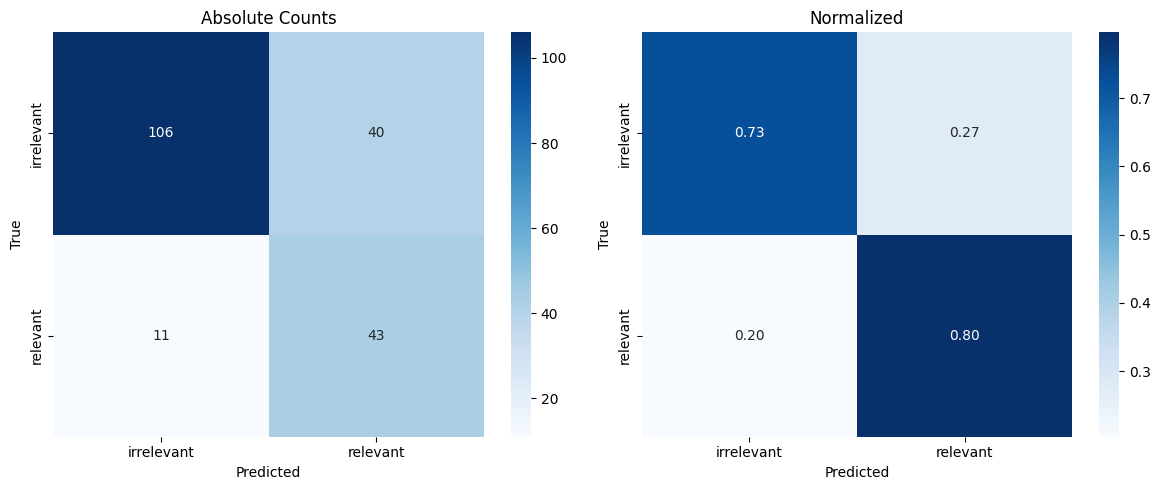

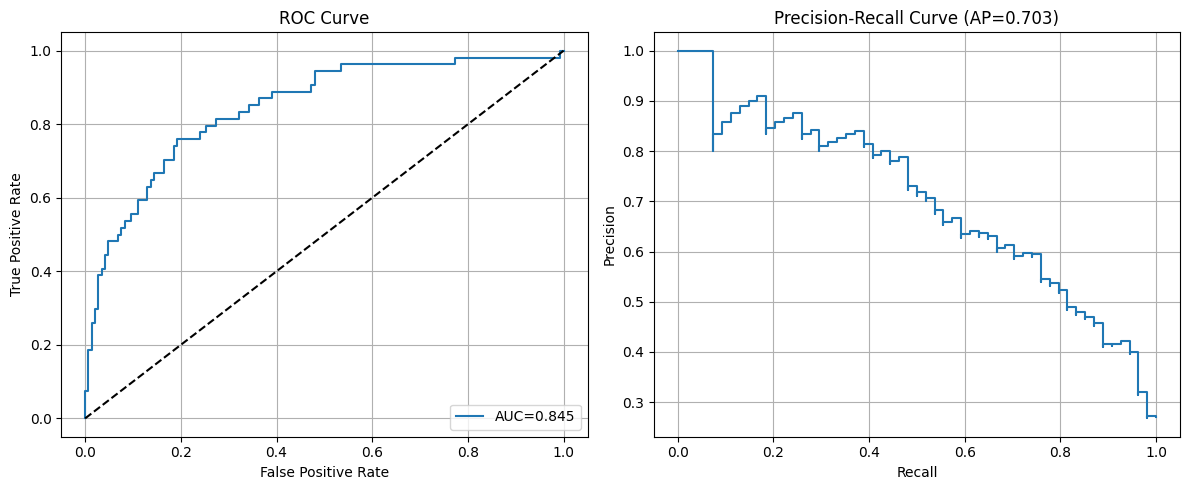


Model saved as model_tfidf_bilstm_basic_gridsearch.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

#for caching
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")

pipeline_bilstm = Pipeline([
    ("embed", FastTextVectorizer(lang='de', 
                                 model_dir=f'{root_path}/src/fasttext_embeddings', 
                                 max_len=1000, #bc we have max 1000 tokens for a segment 
                                 mode='sequence',
                                 cache_key=ft_bin,
                                 debug=True)),  
    ("clf", make_bilstm_skorch(
        max_epochs=30,
        optimizer=torch.optim.Adam,
        lr=1e-3,
        batch_size=16,
        embedding_dim=300,
        hidden_dim=512,
        num_layers=1,
        dropout_embedding=0.1,
        dropout_recurrent=0.2,
        dropout_output=0.5,
        bidirectional=True,
        out_dim=2,
        criterion_fn=nn.CrossEntropyLoss,
        random_state=42,
        force_cuda=True,
        trial=None,
        # early stopping
        use_early_stopping=True,
        es_monitor="valid_f2",
        es_patience=5,
        es_threshold=1e-4,
        es_threshold_mode="rel",
        es_lower_is_better=False
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Grid — BiLSTM edge-aware fine search (~36 runs)
param_grid = {
    "clf__lr": [8e-4, 2.7e-3, 3.0e-3],            # TPE best near upper bound → probe slightly above + one lower band
    "mlp_pos_weight": [4.0, 6.0],                 # mapped to clf__criterion__weight internally (pos class)
    "clf__optimizer__weight_decay": [0.0, 1e-5],  # tiny L2 helped without hurting convergence
    "clf__module__dropout_output": [0.25, 0.30, 0.35],  # TPE at lower edge (0.30) → expand downward to 0.25 and slightly up
    # fixed from best TPE pattern (low importance / stable across top trials):
    "clf__batch_size": [16],
    "clf__module__hidden_dim": [384],
    "clf__module__dropout_embedding": [0.05],
    "clf__module__dropout_recurrent": [0.15],
    "clf__criterion__label_smoothing": [0.04],
}



model_name = "tfidf_bilstm_basic_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_bilstm,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead with fasttext embeddings
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

**b) biLSTM based on advanced preprocessed data**

In [4]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

biLSTM TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


[FastTextVectorizer] LOADING .bin from c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code/src/fasttext_embeddings\cc.de.300.bin
[FastTextVectorizer] CACHED under ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\G

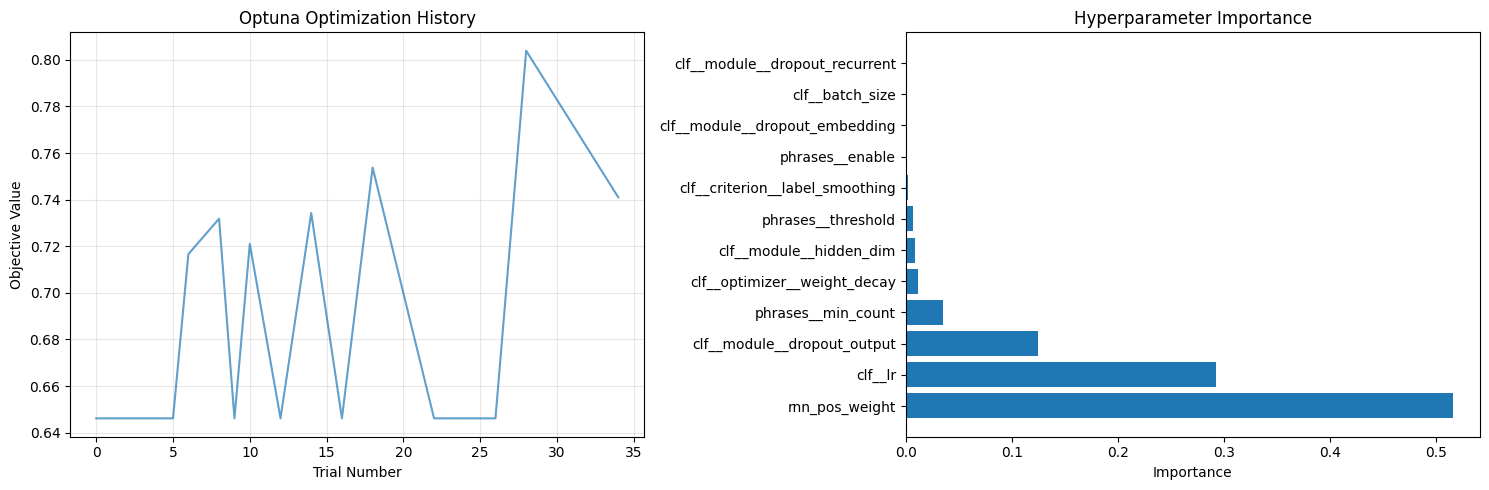


2. Parameter Value Distributions:


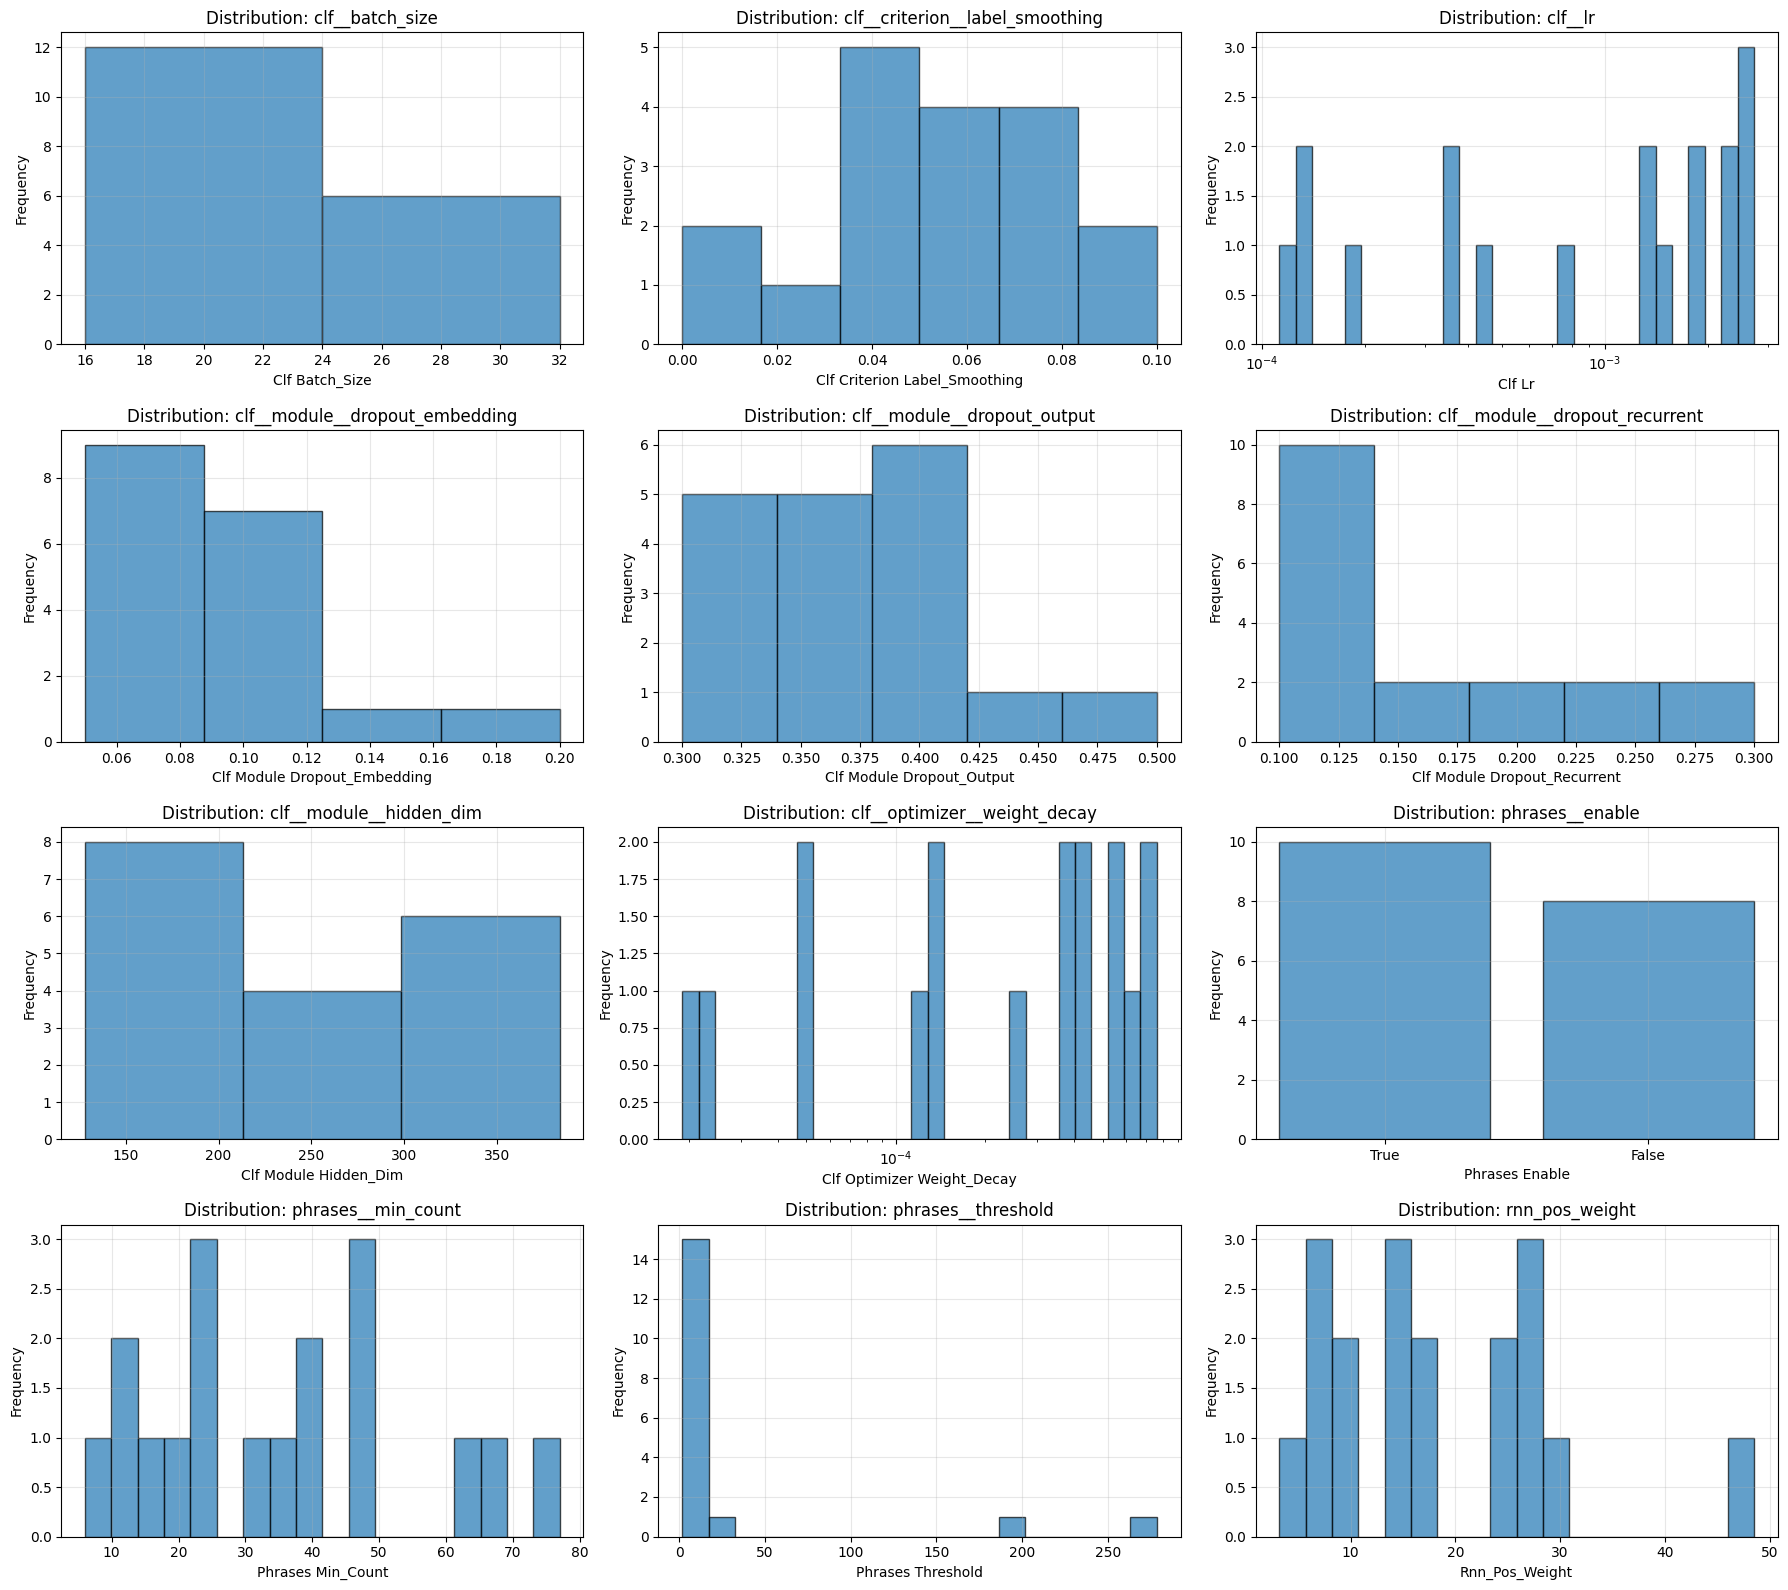


3. Performance vs Individual Parameters:


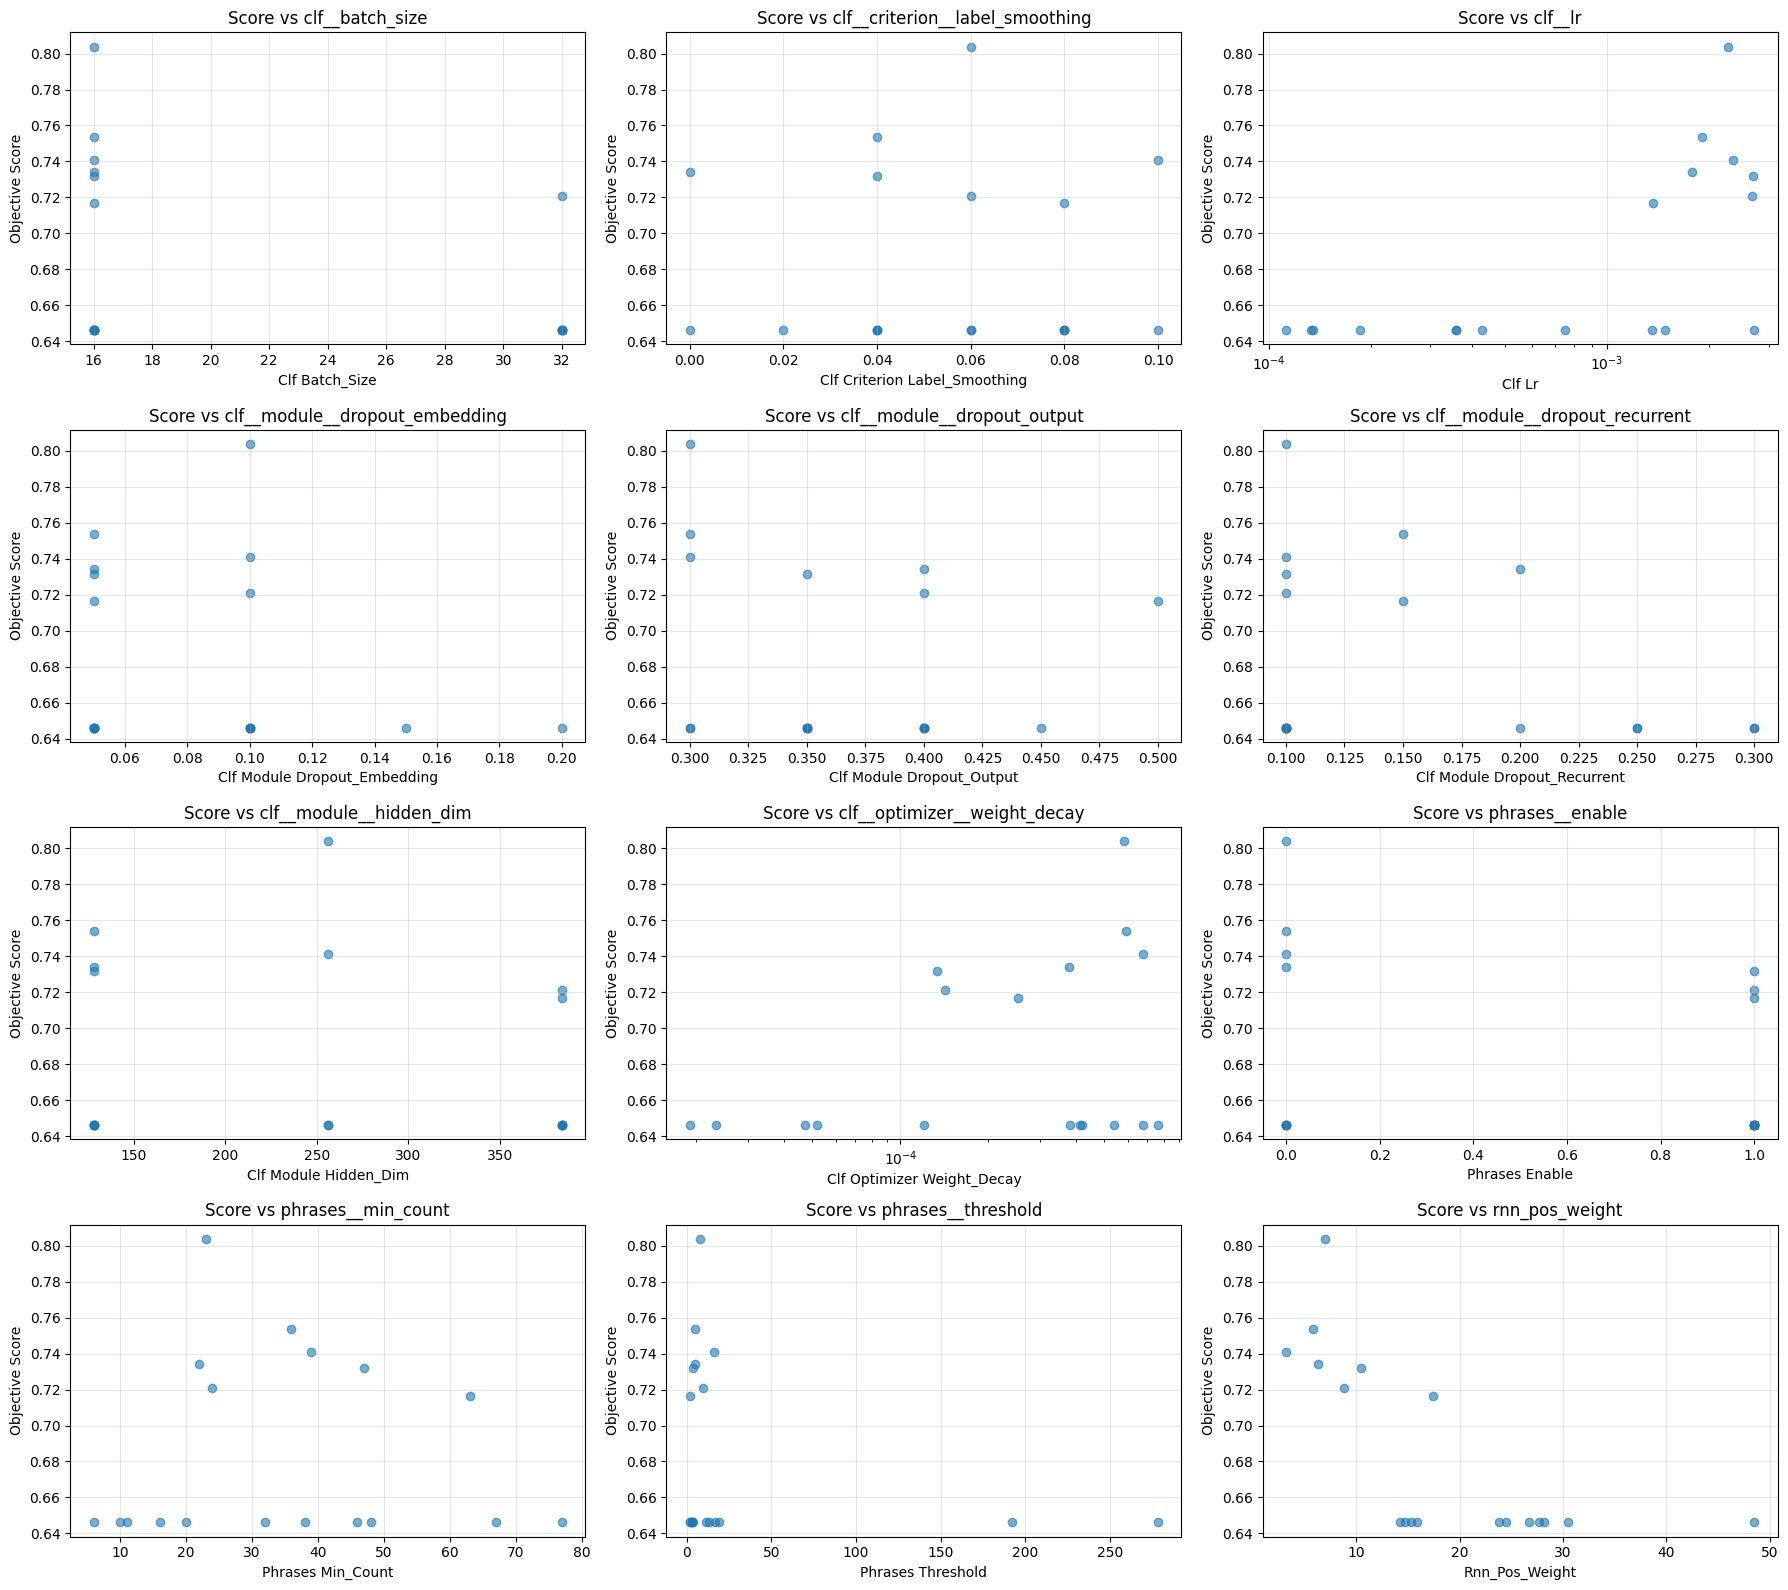


4. Convergence Analysis:


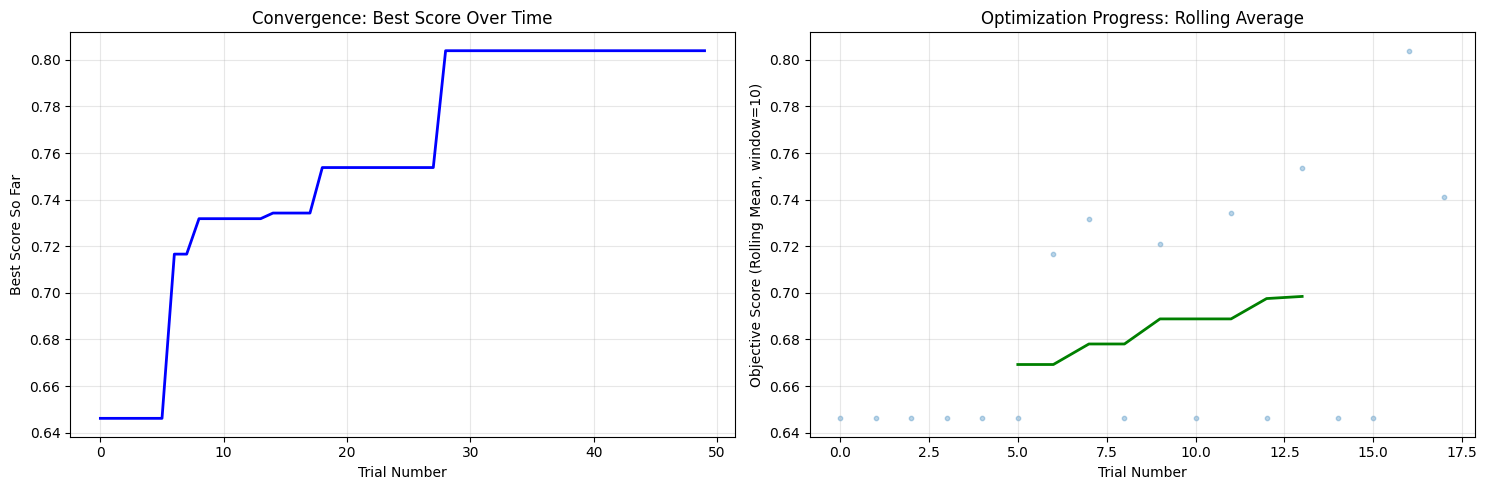


5. Trial Status Overview:


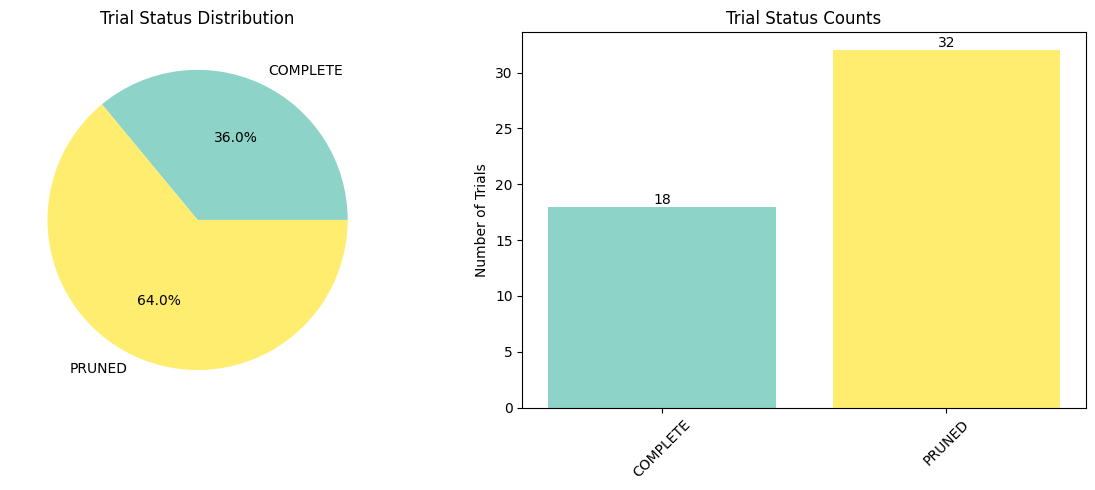


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_embedding dropout_output dropout_recurrent hidden_dim   weight_decay enable       min_count    threshold    rnn_pos_weight
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    28      0.8039     16           0.0600       0.0023       0.1000       0.3000       0.1000       256          0.0006       False        23           7.7219       6.9854      
2    18      0.7538     16           0.0400       0.0019       0.0500       0.3000       0.1500       128          0.0006       False        36           5.1780       5.8052      
3    34      0.7410     16           0.1000       0.0024       0.1000       0.3000       0.1000       256          0.0007       False        39           16.2260      3.1971      
4    14      0.7342     16           0.000

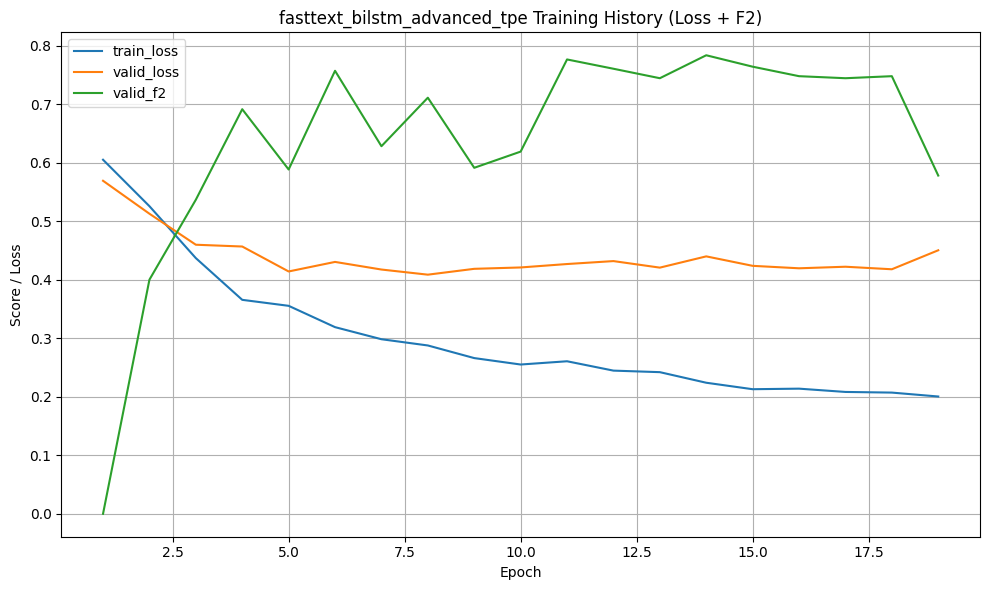


Optimizing threshold with nested cross-validation (coarse-to-fine)...
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.

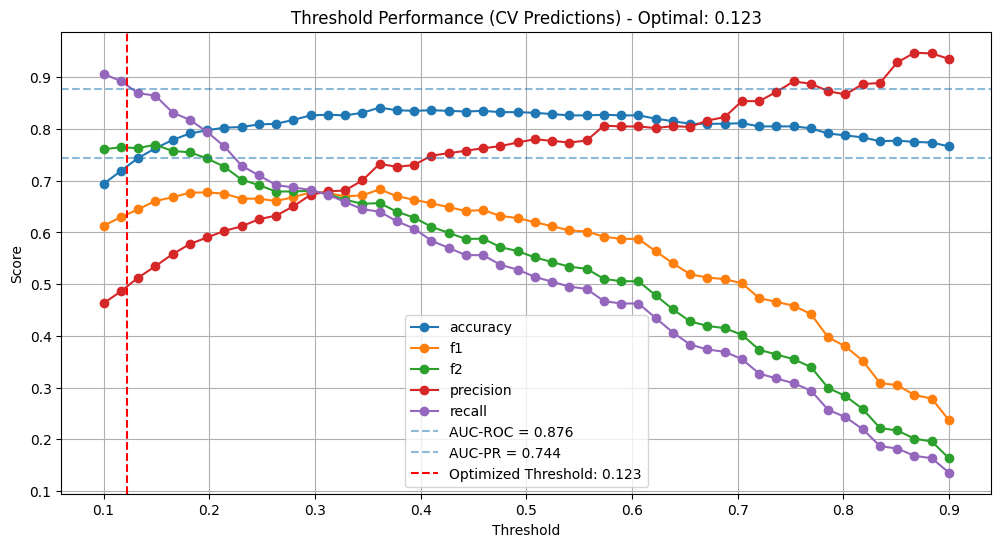

[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

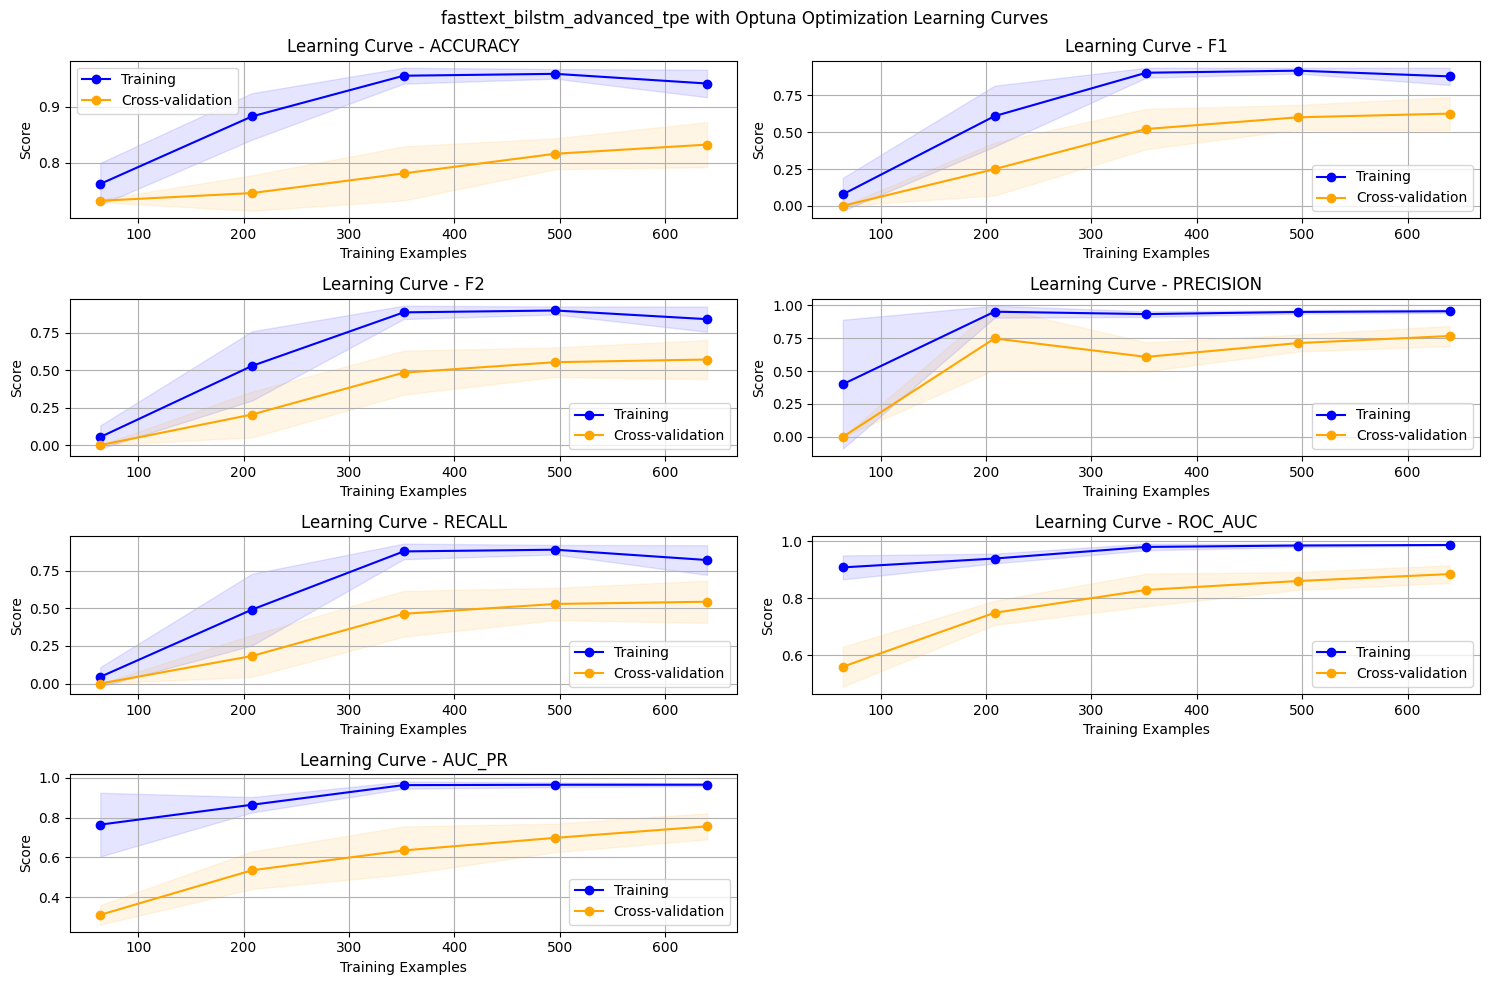


Final Threshold: 0.12
F2-score with default threshold (0.5): 0.549

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       146
           1       0.59      0.78      0.67        54

    accuracy                           0.80       200
   macro avg       0.75      0.79      0.76       200
weighted avg       0.82      0.80      0.80       200

Additional Metrics:
Accuracy   0.795
F2-score   0.732
AUC-ROC    0.847
AUC-PR     0.736



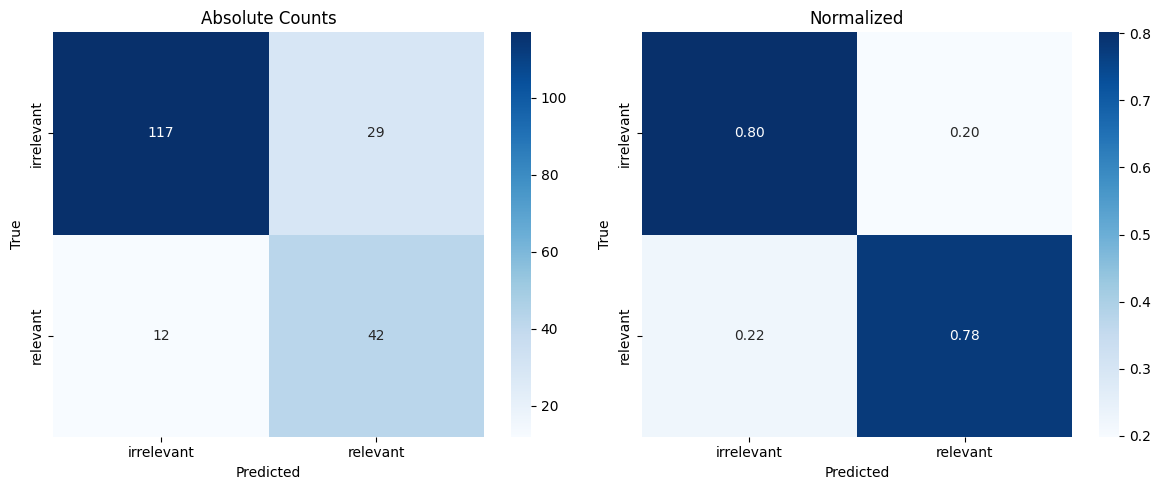

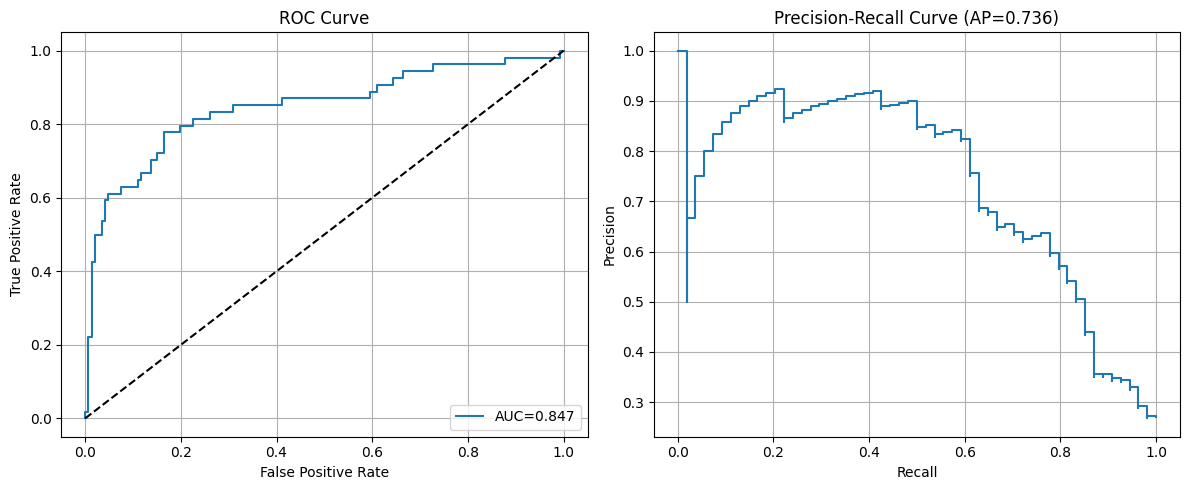


Model saved as model_fasttext_bilstm_advanced_tpe.joblib


In [ ]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

#for caching
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")

pipeline_bilstm = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(lang='de', 
                                 model_dir=f'{root_path}/src/fasttext_embeddings', 
                                 max_len=1000, #bc we have max 1000 tokens for a segment 
                                 mode='sequence',
                                 cache_key=ft_bin,
                                 debug=True)),  
    ("clf", make_bilstm_skorch(
        max_epochs=30,
        optimizer=torch.optim.Adam,
        lr=1e-3,
        batch_size=16,
        embedding_dim=300,
        hidden_dim=512,
        num_layers=1,
        dropout_embedding=0.1,
        dropout_recurrent=0.2,
        dropout_output=0.5,
        bidirectional=True,
        out_dim=2,
        criterion_fn=nn.CrossEntropyLoss,
        random_state=42,
        force_cuda=True,
        trial=None,
        # early stopping
        use_early_stopping=True,
        es_monitor="valid_f2",
        es_patience=5,
        es_threshold=1e-4,
        es_threshold_mode="rel",
        es_lower_is_better=False
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    # Learning rate for Adam optimizer — paper uses 1e-3, search between 1e-4 and 3e-3
    "clf__lr": lambda t: t.suggest_float("clf__lr", 1e-4, 3e-3, log=True),

    # Batch size — 32 as in Adhikari et al. -> 16 for our use might be better
    "clf__batch_size": lambda t: t.suggest_categorical("clf__batch_size", [16, 32]),

    # Hidden dimension of BiLSTM — paper uses 512, allow a structured search
    "clf__module__hidden_dim": lambda t: t.suggest_int("clf__module__hidden_dim", 128, 512, step=128),

    # Dropout applied to the max-pooled document vector (after BiLSTM)
    # Paper recommends 0.5
    "clf__module__dropout_output": lambda t: t.suggest_float("clf__module__dropout_output", 0.3, 0.6, step=0.05),

    # Dropout on input embeddings (before BiLSTM)
    # Paper uses embedding dropout = 0.1
    "clf__module__dropout_embedding": lambda t: t.suggest_float("clf__module__dropout_embedding", 0.05, 0.2, step=0.05),

    # Recurrent dropout (applied via WeightDrop on hidden→hidden connections)
    # Paper uses 0.2
    "clf__module__dropout_recurrent": lambda t: t.suggest_float("clf__module__dropout_recurrent", 0.1, 0.3, step=0.05),

    # Optional weight decay (L2 regularization) for Adam optimizer
    "clf__optimizer__weight_decay": lambda t: t.suggest_float("clf__optimizer__weight_decay", 1e-5, 1e-3, log=True),

    # Class weighting for positive class (due to class imbalance)
    # Search range based on imbalance ratio
    "clf__criterion__weight": lambda t: torch.tensor([1.0, t.suggest_float("rnn_pos_weight", 1.0, 50.0)], dtype=torch.float32),

    # Label smoothing — adds regularization in low-data settings
    "clf__criterion__label_smoothing": lambda t: t.suggest_float("clf__criterion__label_smoothing", 0.0, 0.1, step=0.02),

    # 3 Parameters enabled in our advanced (multi word grouping) pipeline.
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),        
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "fasttext_bilstm_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_bilstm,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "bilstm",
    n_trials=50,  # Intelligent search with early stopping
    n_startup_trials=5, # less aggressive prunning
    n_warmup_steps=5,  # first 5 epochs not pruned
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead with fasttext embeddings
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



biLSTM GridSearch advanced

Starting Optuna hyperparameter optimization ...
[FastTextVectorizer] LOADING .bin from c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code/src/fasttext_embeddings\cc.de.300.bin
[FastTextVectorizer] CACHED under ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer

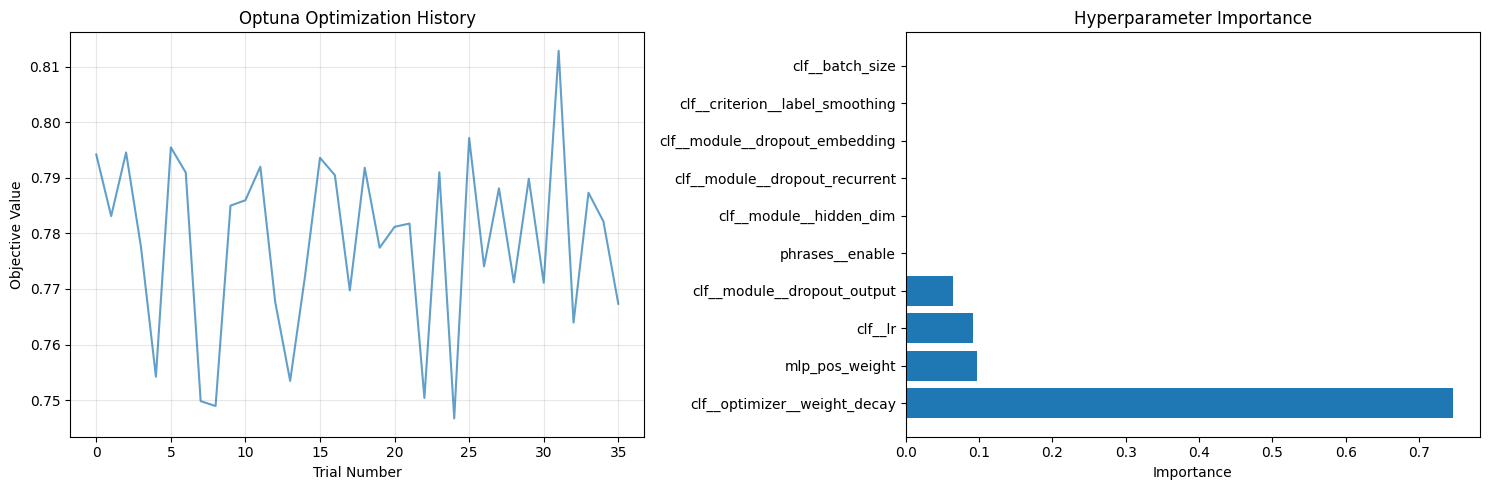


2. Parameter Value Distributions:


c:\Users\tdoro\Documents\GitHub\bachelorsthesis_notebook_code\src\optuna_visualizations.py:208: RuntimeWarning: divide by zero encountered in log10
  np.log10(min(numeric_values)),
c:\Users\tdoro\miniconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\tdoro\miniconda3\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


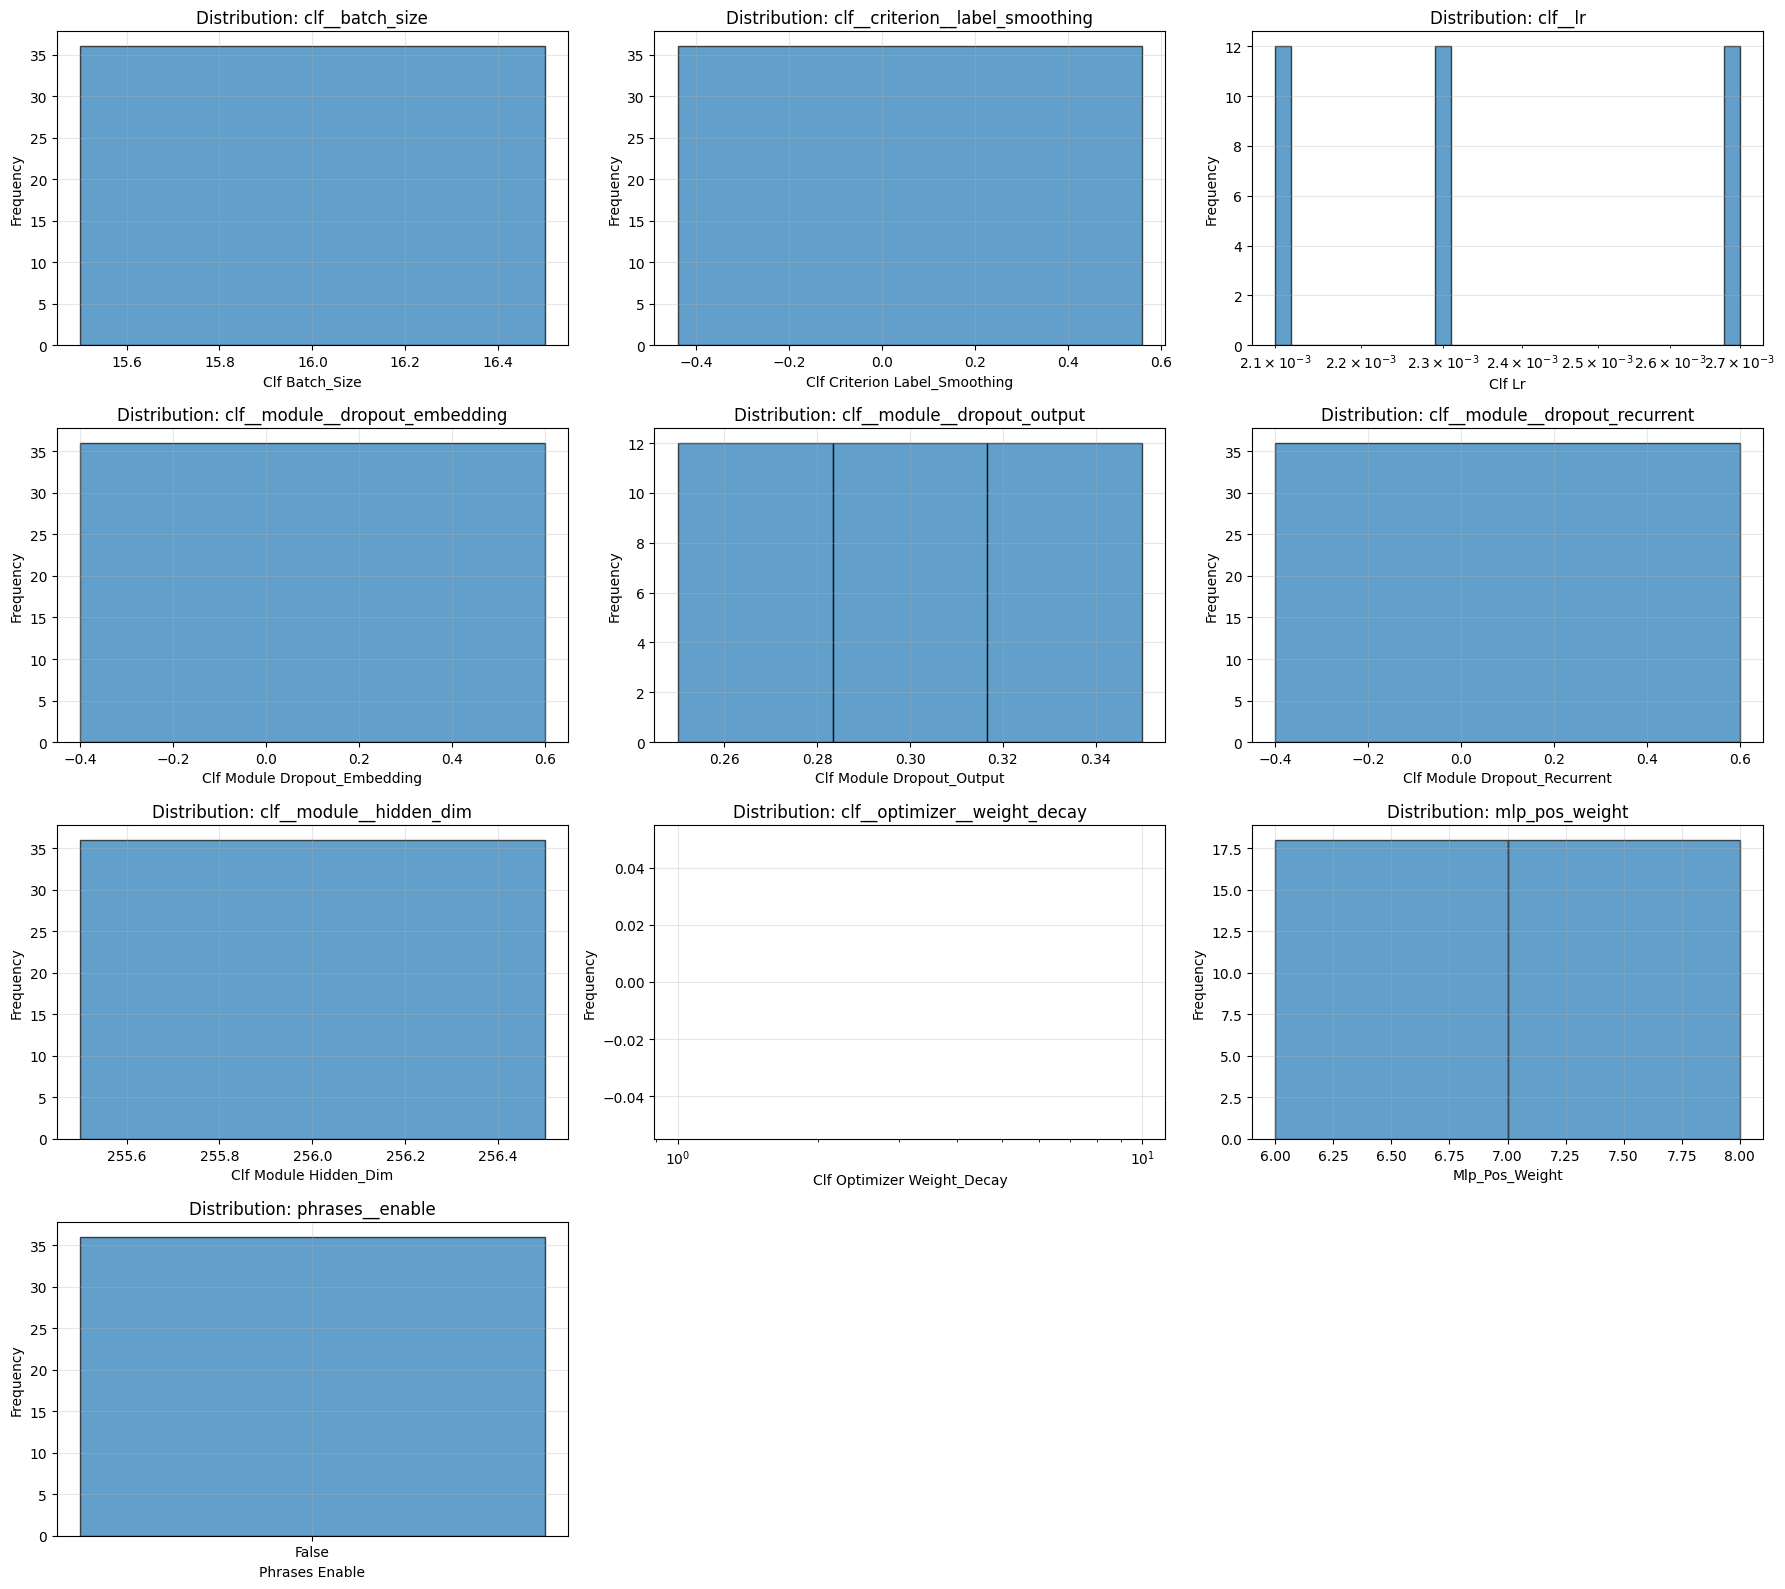


3. Performance vs Individual Parameters:


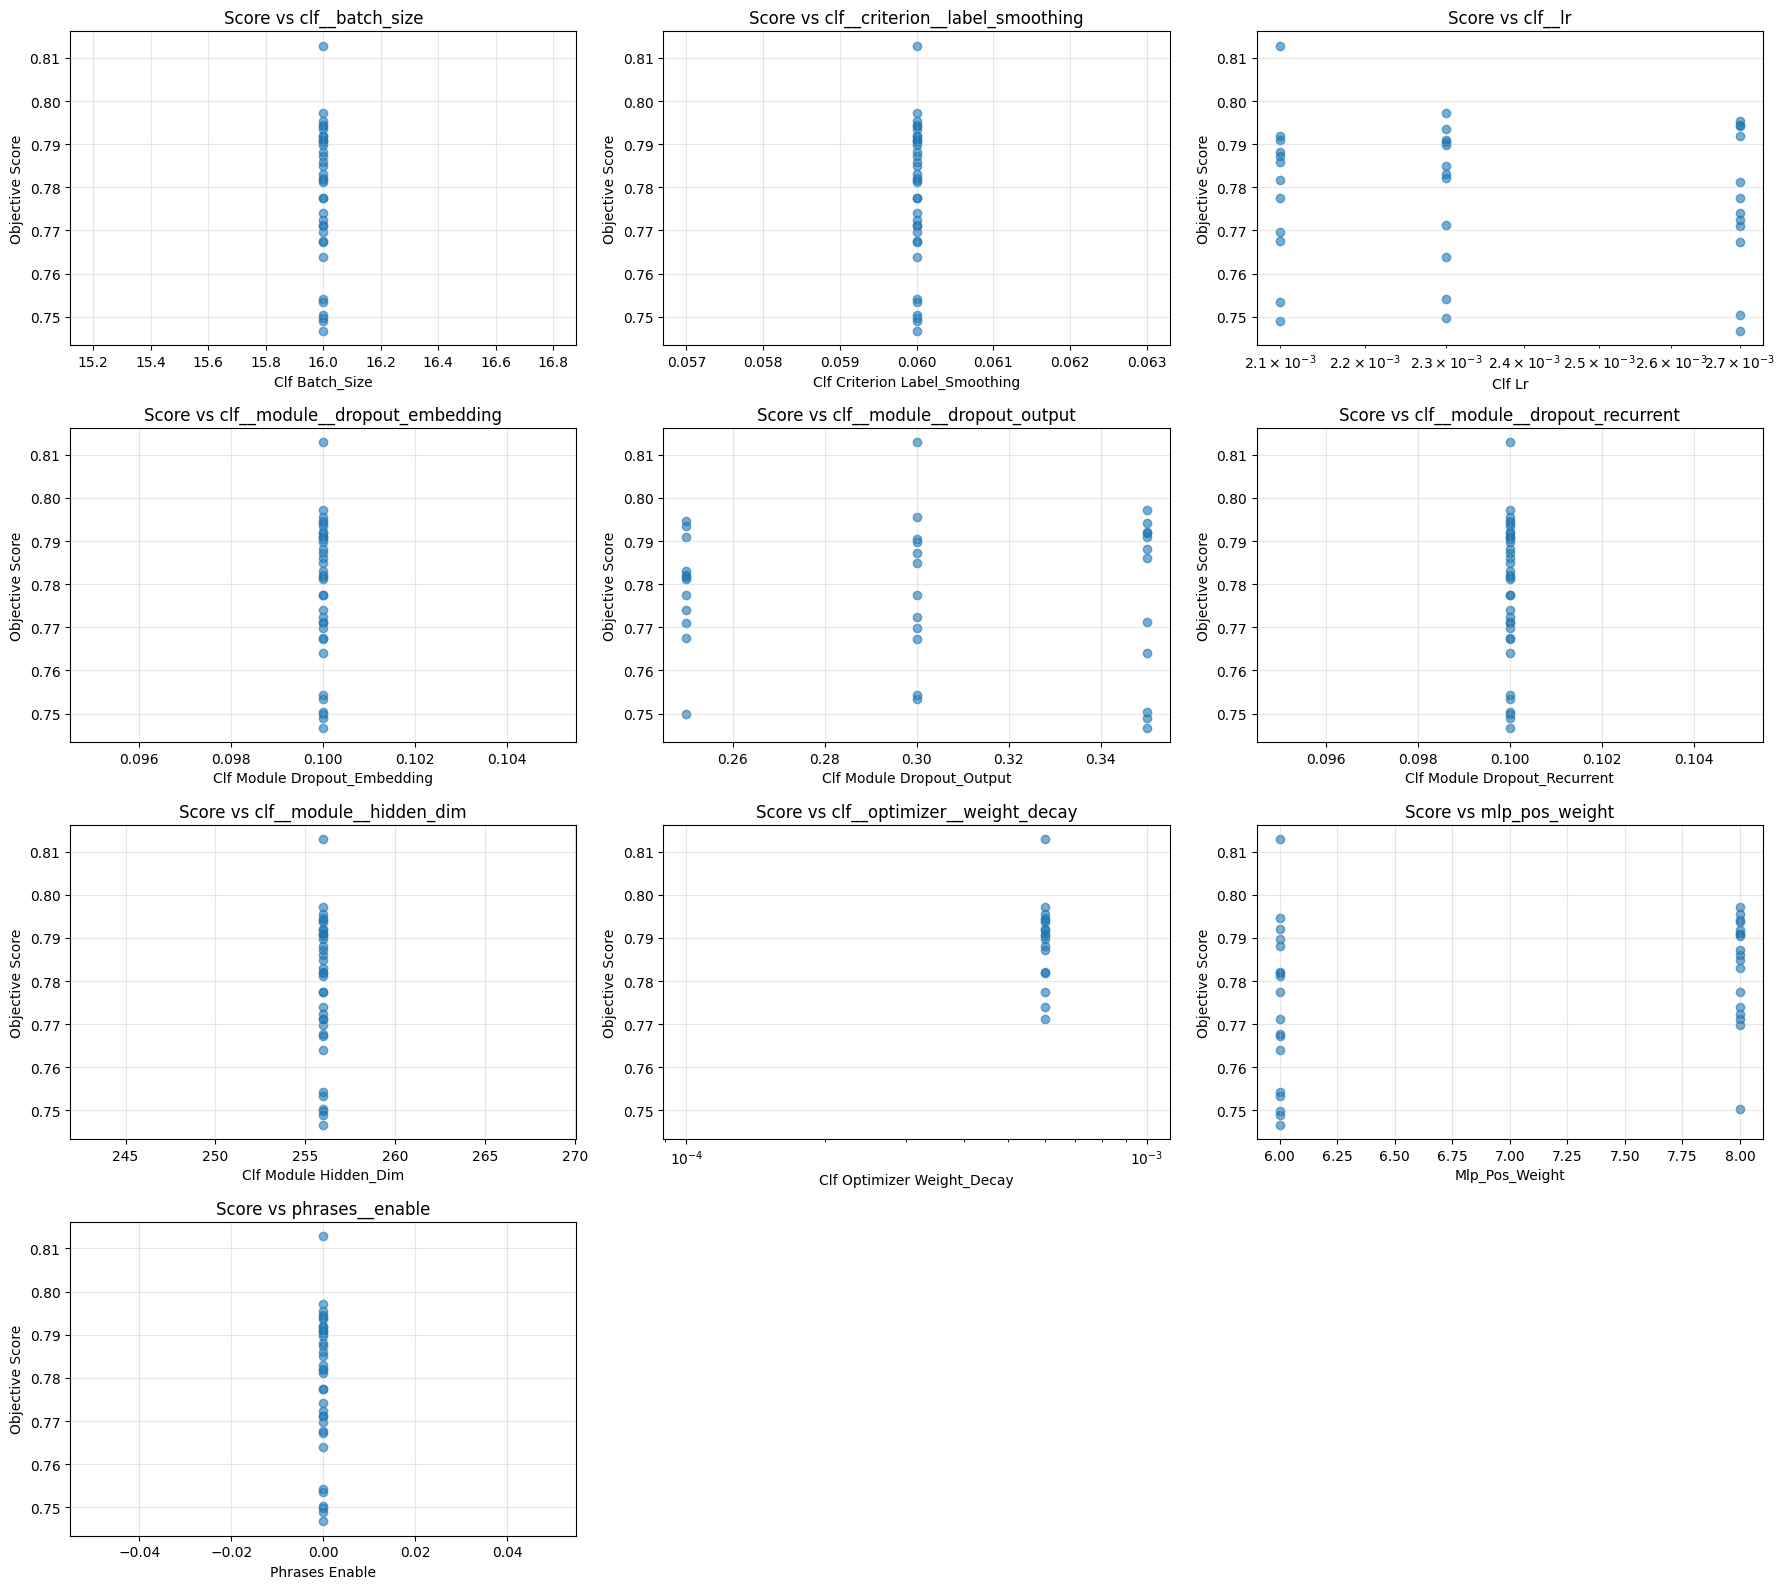


4. Convergence Analysis:


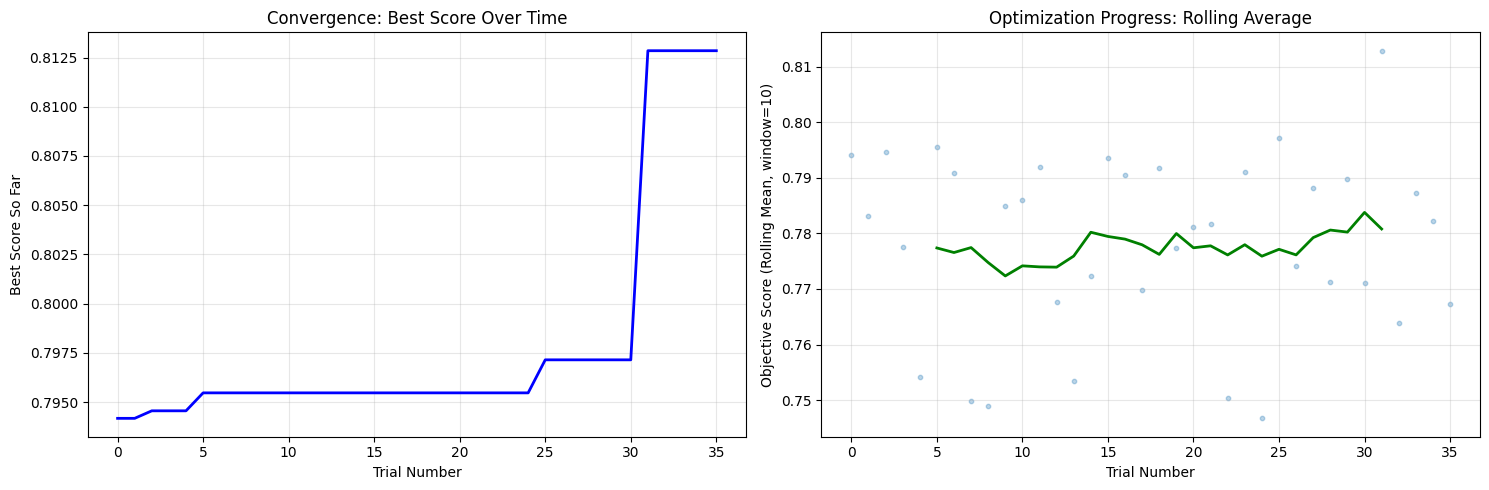


5. Trial Status Overview:


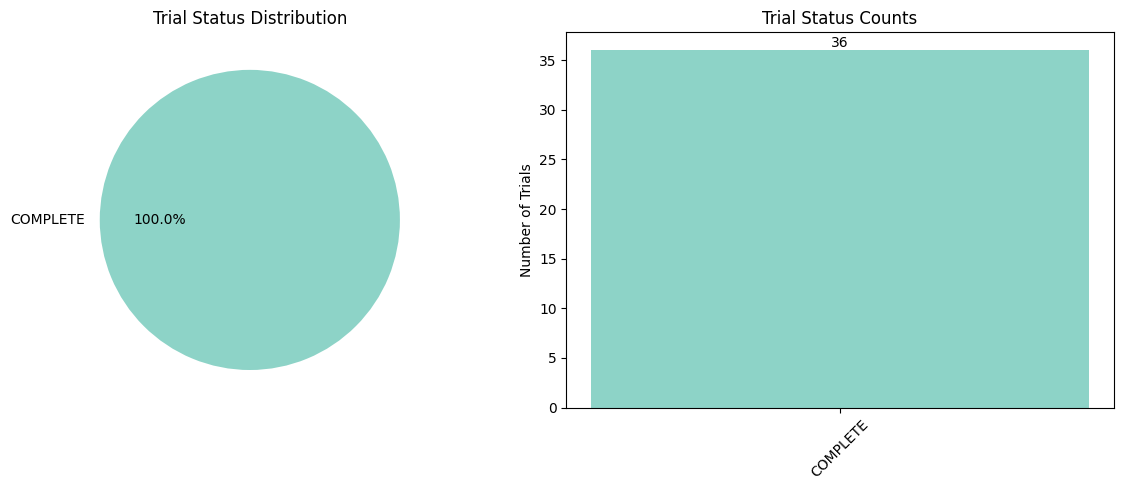


6. Top 10 Best Trials:
Rank Trial#  Score      batch_size   label_smoothing lr           dropout_embedding dropout_output dropout_recurrent hidden_dim   weight_decay mlp_pos_weight enable      
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1    31      0.8128     16           0.0600       0.0021       0.1000       0.3000       0.1000       256          0.0006       6.0000       False       
2    25      0.7971     16           0.0600       0.0023       0.1000       0.3500       0.1000       256          0.0006       8.0000       False       
3    5       0.7955     16           0.0600       0.0027       0.1000       0.3000       0.1000       256          0.0006       8.0000       False       
4    2       0.7946     16           0.0600       0.0027       0.1000       0.2500       0.1000       256          0.0006       6.0000       False       
5    0       0.794

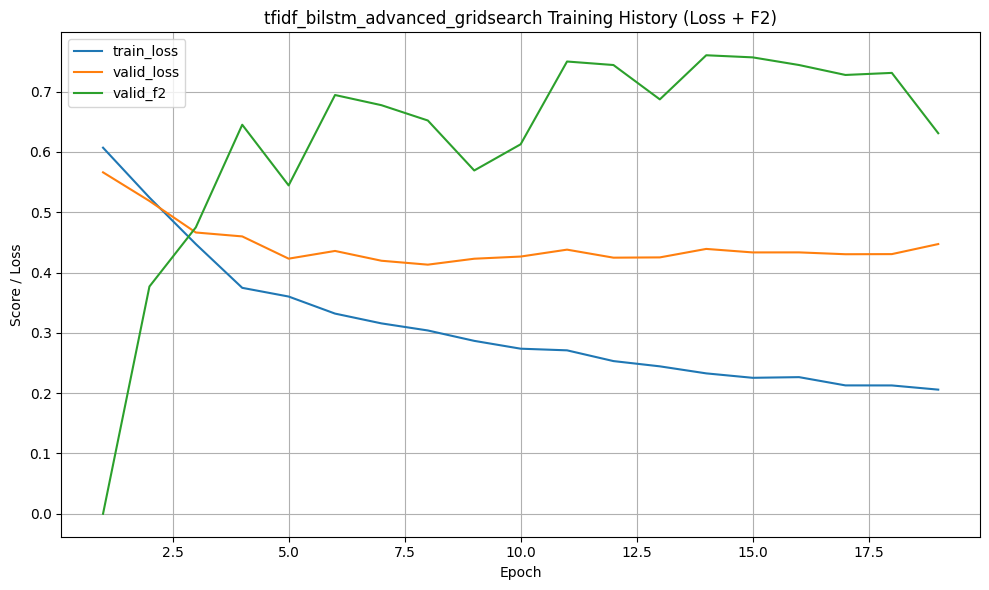


Optimizing threshold with nested cross-validation (coarse-to-fine)...
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.

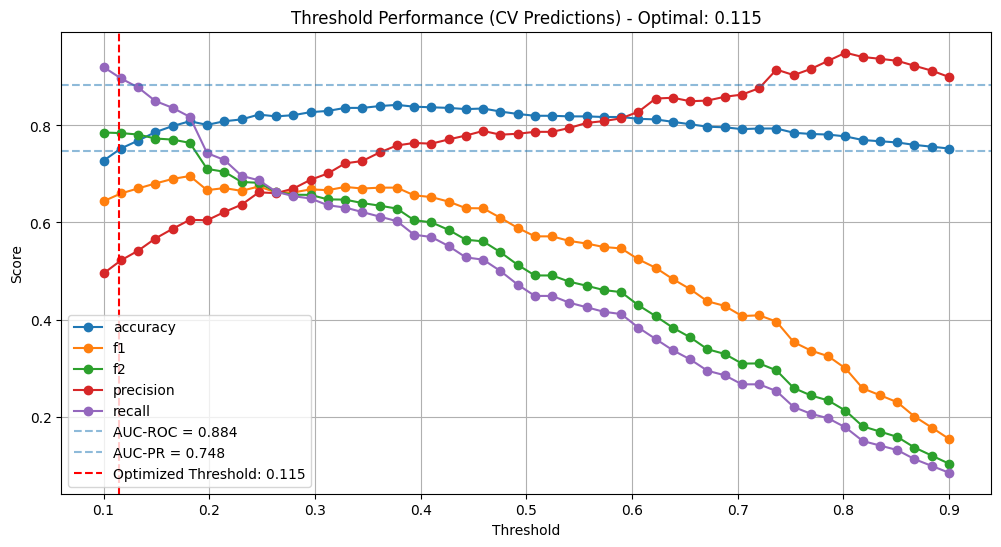

[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')


c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users\\tdoro\\Documents\\GitHub\\bachelorsthesis_notebook_code\\src\\fasttext_embeddings\\cc.de.300.bin', 'sequence')
[FastTextVectorizer] CACHE HIT for ('c:\\Users

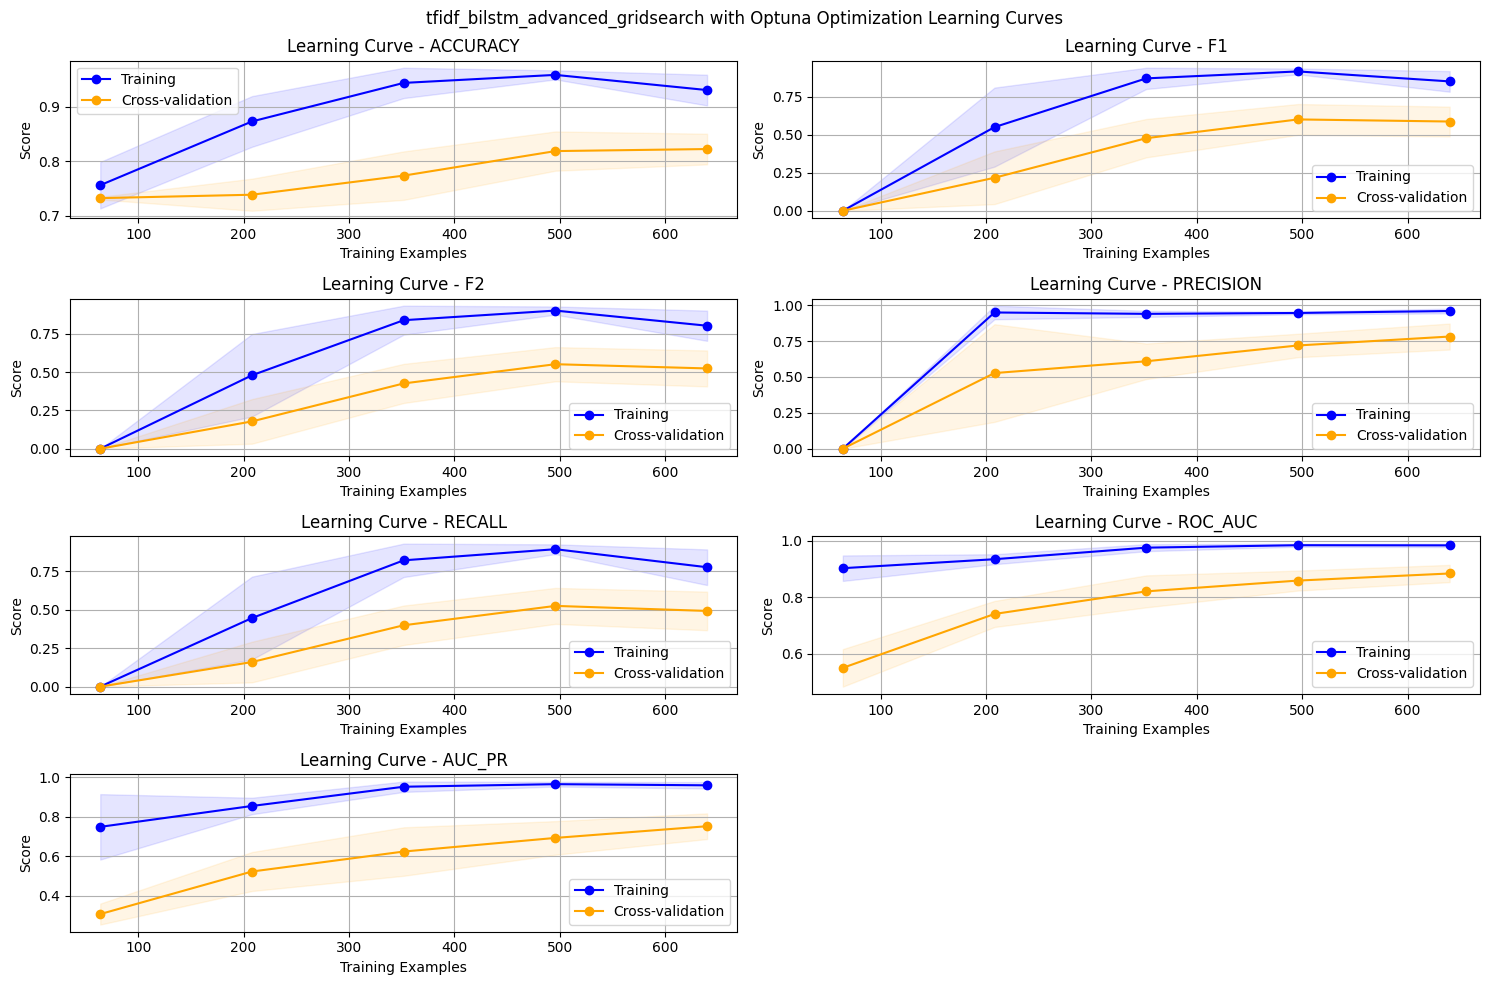


Final Threshold: 0.12
F2-score with default threshold (0.5): 0.613

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       146
           1       0.51      0.81      0.63        54

    accuracy                           0.74       200
   macro avg       0.71      0.76      0.71       200
weighted avg       0.80      0.74      0.75       200

Additional Metrics:
Accuracy   0.740
F2-score   0.728
AUC-ROC    0.843
AUC-PR     0.728



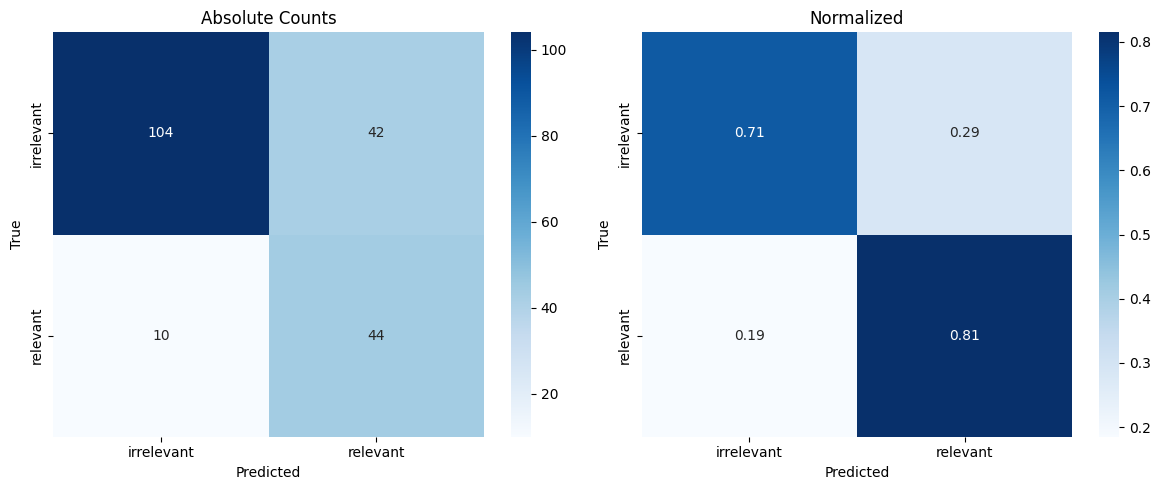

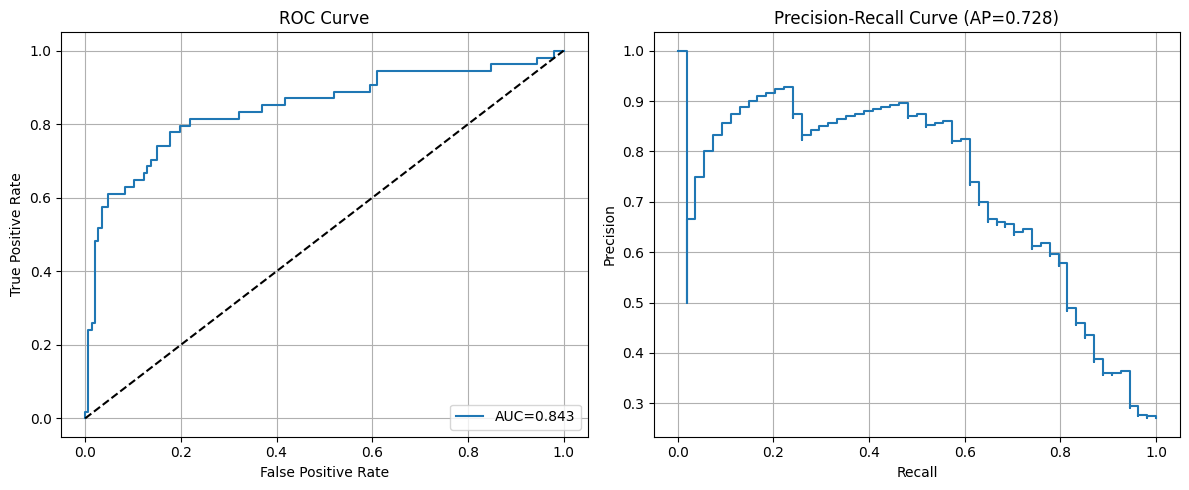


Model saved as model_tfidf_bilstm_advanced_gridsearch.joblib


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

#for caching
ft_bin = os.path.join(root_path, "src", "fasttext_embeddings", "cc.de.300.bin")

pipeline_bilstm = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("embed", FastTextVectorizer(lang='de', 
                                 model_dir=f'{root_path}/src/fasttext_embeddings', 
                                 max_len=1000, #bc we have max 1000 tokens for a segment 
                                 mode='sequence',
                                 cache_key=ft_bin,
                                 debug=True)),  
    ("clf", make_bilstm_skorch(
        max_epochs=30,
        optimizer=torch.optim.Adam,
        lr=1e-3,
        batch_size=16,
        embedding_dim=300,
        hidden_dim=512,
        num_layers=1,
        dropout_embedding=0.1,
        dropout_recurrent=0.2,
        dropout_output=0.5,
        bidirectional=True,
        out_dim=2,
        criterion_fn=nn.CrossEntropyLoss,
        random_state=42,
        force_cuda=True,
        trial=None,
        # early stopping
        use_early_stopping=True,
        es_monitor="valid_f2",
        es_patience=5,
        es_threshold=1e-4,
        es_threshold_mode="rel",
        es_lower_is_better=False
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Grid — BiLSTM ADVANCED, edge-aware fine search (36 runs)
param_grid = {
    "clf__lr": [2.1e-3, 2.3e-3, 2.7e-3],          # best ≈2.3e-3; probe slightly below and above
    "mlp_pos_weight": [6.0, 8.0],                 # maps to clf__criterion__weight (pos class); best ≈7.0
    "clf__optimizer__weight_decay": [0.0, 6e-4],  # compare no L2 vs tiny L2 (best ~6e-4)
    "clf__module__dropout_output": [0.25, 0.30, 0.35],  # TPE hit lower boundary 0.30 → send scouts below (0.25)
    # fixed from TPE best / low-importance knobs:
    "clf__batch_size": [16],
    "clf__module__hidden_dim": [256],
    "clf__module__dropout_embedding": [0.10],
    "clf__module__dropout_recurrent": [0.10],
    "clf__criterion__label_smoothing": [0.06],
    "phrases__enable": [False],                   # best was False; phrase params ignored when disabled
}




model_name = "tfidf_bilstm_advanced_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_bilstm,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name,
    n_jobs=1
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# plot loss curves
net = base_model.named_steps['clf']
plot_skorch_history(net=net, keys=['train_loss', 'valid_loss','valid_f2'])
plt.title(f'{model_name} Training History (Loss + F2)')
plt.show()


# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=25,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1  # Use single thread for learning curves to avoid overhead with fasttext embeddings
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name, 
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")